In [ ]:
library(dplyr)
library(ggplot2)
library(data.table)

setwd("/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM")

source("/mnt/lareaulab/reliscu/code/ggplot_theme.R")

theme_set(default_theme())
options(repr.matrix.max.cols=Inf) 

In [239]:
cell_meta <- fread("/mnt/lareaulab/reliscu/projects/NSF_GRFP/data/scRNA-seq/tasic_2018/ALM/tasic_2018_ALM_STAR_sampleinfo.csv", data.table=FALSE)

In [240]:
cell_meta$cell_subclass <- gsub(" ", "_", cell_meta$cell_subclass)
cell_meta$cell_subclass <- gsub("-", "_", cell_meta$cell_subclass)
cell_meta$cell_subclass <- gsub("/", "_", cell_meta$cell_subclass, fixed=TRUE)

In [241]:
sort(table(cell_meta$cell_subclass))


        L4       Peri         CR      Meis2        SMC       VLMC   Serpinf1 Macrophage       Endo      Oligo        L6b       Sncg      Astro    L2_3_IT      L6_CT      L5_PT      L6_IT         NP      Pvalb      Lamp5        Sst        Vip      L5_IT 
         3          4         11         11         55         72         78         85         96         98        145        148        215        325        350        368        394        542        896        913       1139       1224       2401 

In [242]:
get_top_corr_mods <- function(network_dir, pseudobulk_legend, top_qval_mods_df) {
    ctypes <- top_qval_mods_df$Cell_type
    top_corr_mods_list <- vector(mode="list", length=length(ctypes))

    for (i in seq_along(ctypes)) {
        # Get working cell type proportion in each sample
        mask <- pseudobulk_legend$Cell.type == ctypes[i]
        n_cells_per_sample <- colSums(pseudobulk_legend[mask, -c(1, 2)])
        frac_per_sample <- n_cells_per_sample/nrow(pseudobulk_legend) 

        if (var(frac_per_sample) > 0) {
            # Get most enriched cell type module
            old_mod <- top_qval_mods_df$Module[i]
            ME_df <- fread(top_qval_mods_df$ME_path[i], data.table=FALSE)
            ME_vec <- ME_df[,grep(paste0("^", old_mod, "$"), colnames(ME_df))]
            old_corr <- cor(frac_per_sample, ME_vec)

            # Traverse networks to find module most correlated to cell type abundance
            networks <- list.dirs(file.path(getwd(), network_dir), full.names=TRUE, recursive=FALSE)
            networks <- networks[lengths(lapply(networks, list.files)) > 0]

            ME_corrs_list <- lapply(seq_along(networks), function(j) {
                ME_path <- list.files(networks[j])[grep("eigengene", list.files(networks[j]))]
                ME_df <- fread(file.path(networks[j], ME_path), data.table=FALSE)

                ME_corrs <- apply(ME_df[,-1, drop=FALSE], 2, function(ME) {
                    cor(ME, frac_per_sample)
                })

                new_mod <- names(which.max(ME_corrs))
                new_corr <- ME_corrs[which.max(ME_corrs)]
                
                # Save the network the module came from
                network_id <- sapply(strsplit(networks[j], "/"), function(x) x[length(x)])
                
                data.frame(
                    Cell_type=ctypes[i],
                    Cor=new_corr,
                    Old_cor=old_corr,
                    Module=new_mod,
                    Old_module=old_mod,
                    Network=network_id,
                    Old_network=top_qval_mods_df$Network[i],
                    Pseudobulk_SD=round(sd(n_cells_per_sample), 2),
                    New_ME_path=file.path(networks[j], ME_path)
                )
            })
            ME_corrs <- do.call(rbind, ME_corrs_list)
            
            top_corr_mods_list[[i]] <- ME_corrs %>%
                arrange(Network, Module) %>%
                slice_max(Cor, with_ties=F)
        }
    }

    top_corr_mods_df <- do.call(rbind, top_corr_mods_list)
    top_corr_mods_df %>%
        arrange(Cor)
}

get_top_corr_mod_stats <- function(top_corr_mods_df) {
    ctypes <- top_corr_mods_df$Cell_type

    top_corr_mods_df$Mod_stats_path <- sapply(top_corr_mods_df$New_ME_path, function(x) gsub("eigengenes", "statistics", x))

    mod_stats <- fread(top_corr_mods_df$Mod_stats_path[1], data.table=FALSE)
    col_idx <- which(colnames(mod_stats) %in% c("PC1VE", "MeanExpr", "Specificity", "Homogeneity"))
    col_idx <- sort(c(col_idx, grep("^Unique", colnames(mod_stats))))

    stats <- c()
    for (i in seq_along(ctypes)) {
        mod <- top_corr_mods_df$Module[i]
        mod_stats <- fread(top_corr_mods_df$Mod_stats_path[i], data.table=FALSE)
        colnames(mod_stats)[grep("^Unique", colnames(mod_stats))] <- "Unique_members" 
        stats <- rbind(stats, mod_stats[mod_stats$Module == mod, col_idx])
    }

    top_corr_mods_df <- cbind(top_corr_mods_df, stats)
    top_corr_mods_df
}

plot_ctype_abundance_vs_ME <- function(pseudobulk_legend, top_qval_mods_df) {
    options(repr.plot.width=6, repr.plot.height=6)

    ctypes <- top_qval_mods_df$Cell_type

    for (i in seq_along(ctypes)) {
        # Get cell type proportion in each sample
        mask <- pseudobulk_legend$Cell.type == ctypes[i]
        n_cells_per_sample <- colSums(pseudobulk_legend[mask, -c(1, 2)])
        frac_per_sample <- n_cells_per_sample/nrow(pseudobulk_legend) 

        # Get eigengene from most enriched cell type module
        mod <- top_qval_mods_df$Module[i]
        ME_df <- fread(top_qval_mods_df$ME_path[i], data.table=FALSE)
        ME_vec <- ME_df[,grep(paste0("^", mod, "$"), colnames(ME_df))]

        df <- data.frame(Frac=frac_per_sample, ME=ME_vec)

        subtitle <- paste(
            top_qval_mods_df$Module[i], top_qval_mods_df$Network_short[i], "\n",
            "Cor:", round(cor(frac_per_sample, ME_vec), 2), "\n",
            "Qval =", formatC(top_qval_mods_df$Qval[i], format="e", digits=1) 
        )

        # Plot cell type proportion vs. module eigengene
        
        print(
            ggplot(df, aes(x=Frac*100, y=ME)) +
                geom_point() +
                theme(
                    plot.title=element_text(hjust=0.5),
                    plot.subtitle=element_text(hjust=0.5),
                    axis.title.x=element_text(size=14),
                    axis.title.y=element_text(size=14)
                ) +
                labs(
                    title=ctypes[i], 
                    subtitle=subtitle
                ) +
                xlab("% cells per sample") +
                ylab("Module eigengene")
        )
    }
    
}

plot_ctype_abundance <- function(pseudobulk_legend, top_qval_mods_df) {
    options(repr.plot.width=15, repr.plot.height=6)

    ctypes <- unique(pseudobulk_legend$Cell.type)

    for (i in seq_along(ctypes)) {
        # Get cell type proportion in each sample
        mask <- pseudobulk_legend$Cell.type == ctypes[i]
        n_cells_per_sample <- colSums(pseudobulk_legend[mask, -c(1, 2)])
        # frac_per_sample <- n_cells_per_sample/nrow(pseudobulk_legend) 

        n_cells_SD <- round(sd(n_cells_per_sample), 2)
        subtitle <- paste("SD =", n_cells_SD)

        # Plot cell type proportion vs. module eigengene
        df <- data.frame(Sample=1:length(n_cells_per_sample), No.cells=n_cells_per_sample)

        options(repr.plot.width=15, repr.plot.height=6)

        print(
            ggplot(df, aes(x=Sample, y=No.cells)) +
                geom_point() +
                geom_line() +
                theme(
                    plot.title=element_text(hjust=0.5),
                    plot.subtitle=element_text(hjust=0.5),
                    axis.title.x=element_text(size=14),
                    axis.title.y=element_text(size=14)
                ) +
                labs(
                    title=ctypes[i], 
                    subtitle=subtitle
                ) +
                xlab("Sample") +
                ylab("# cells per sample")
        )
    }
    
}

Verify enriched modules actually represent a given cell type by plotting cell type abundance vs. the module eigengene

# Round 3 (0.4% var network; PosFDR module definiton)

In [243]:
# network_dir <- "tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules"

# pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_0.4pcntVar_200samples_legend_07-25-48.csv")
# pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
# pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

# top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_PosFDR_top_Qval_modules.csv")

In [244]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [245]:
# # For each (poorly correlated) cell type, see if there exists any module(s) to which they are correlated:

# top_corr_mods_0.4pcnt_PosFDR_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
# top_corr_mods_0.4pcnt_PosFDR_df

In [246]:
# plot_ctype_abundance(pseudobulk_legend)

# Round 3 (0.4% var network; PosBC module definiton)

In [247]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_0.4pcntVar_200samples_legend_07-25-48.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

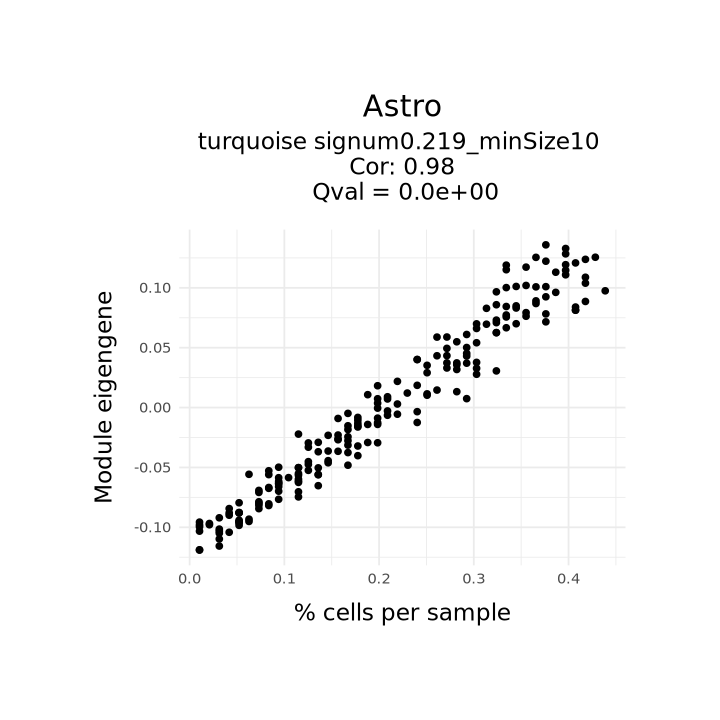

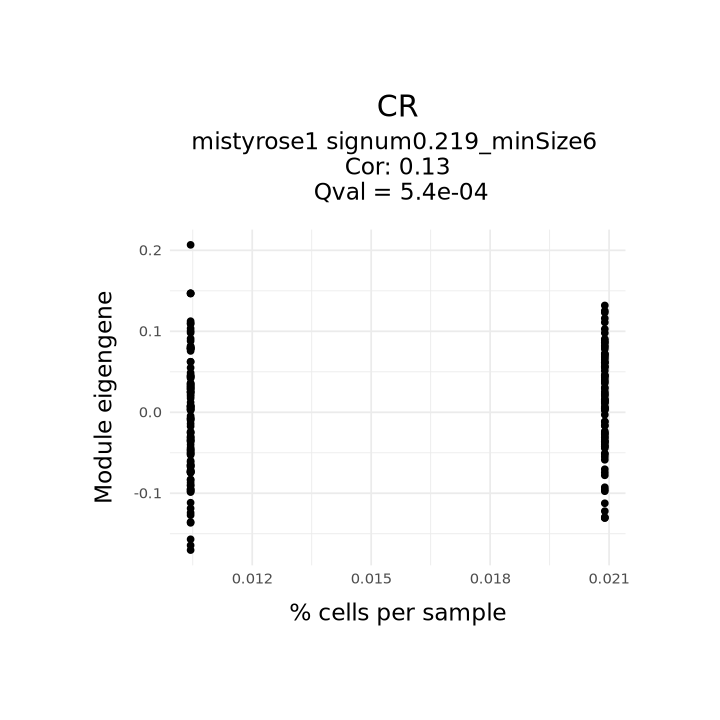

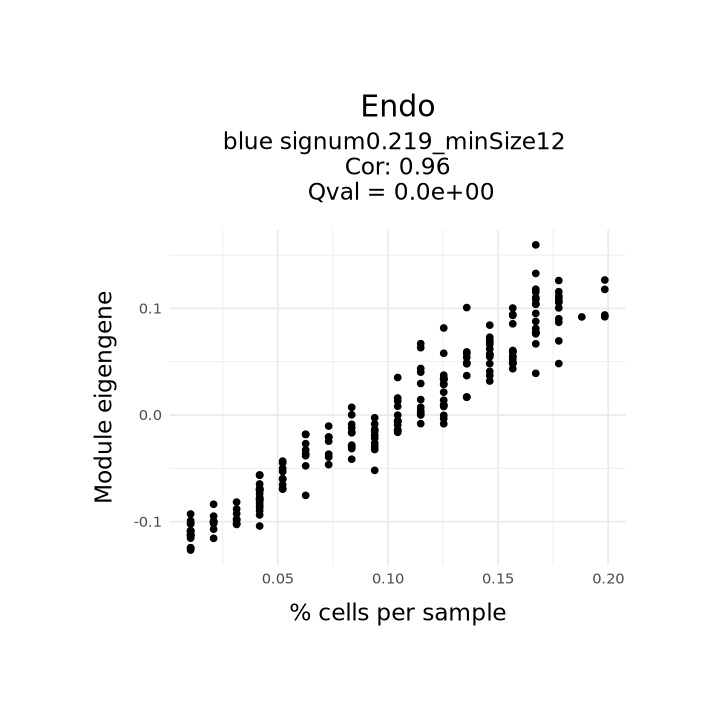

Warning message in cor(frac_per_sample, ME_vec):
“the standard deviation is zero”


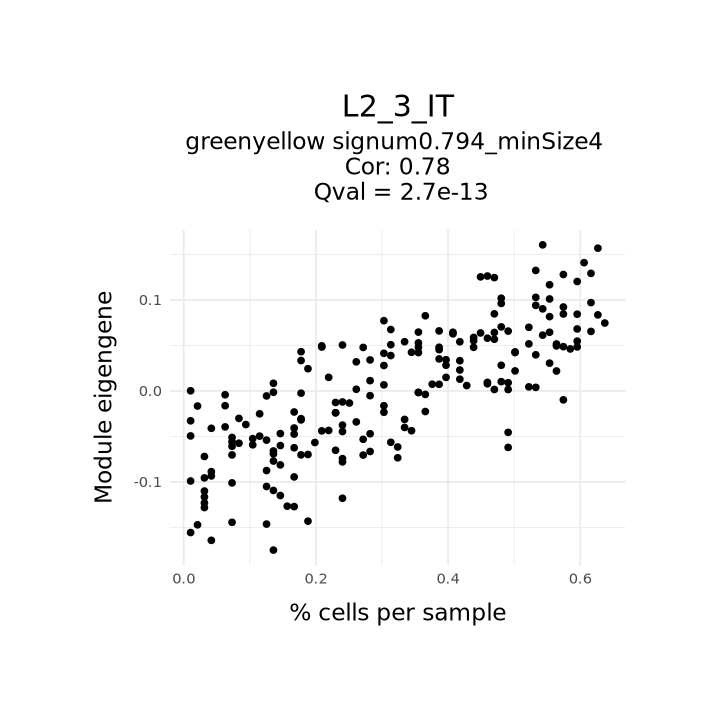

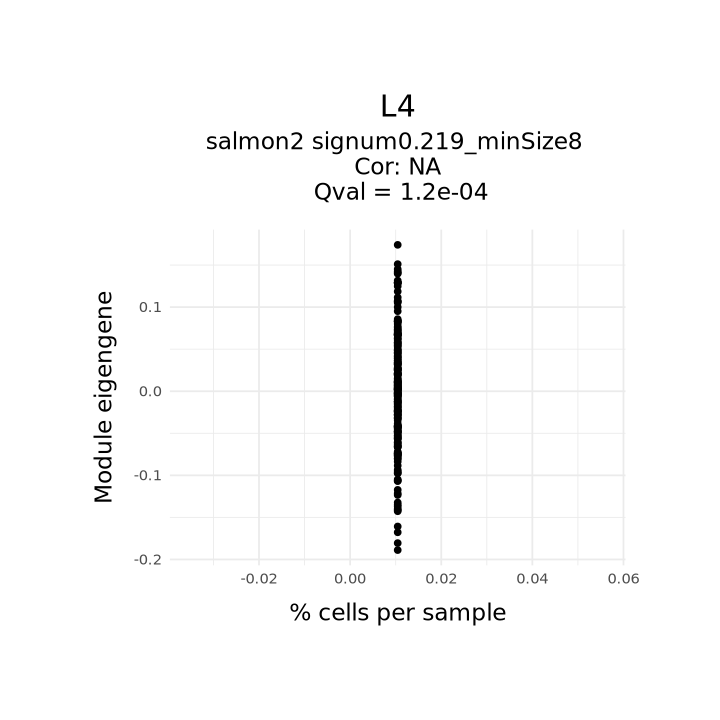

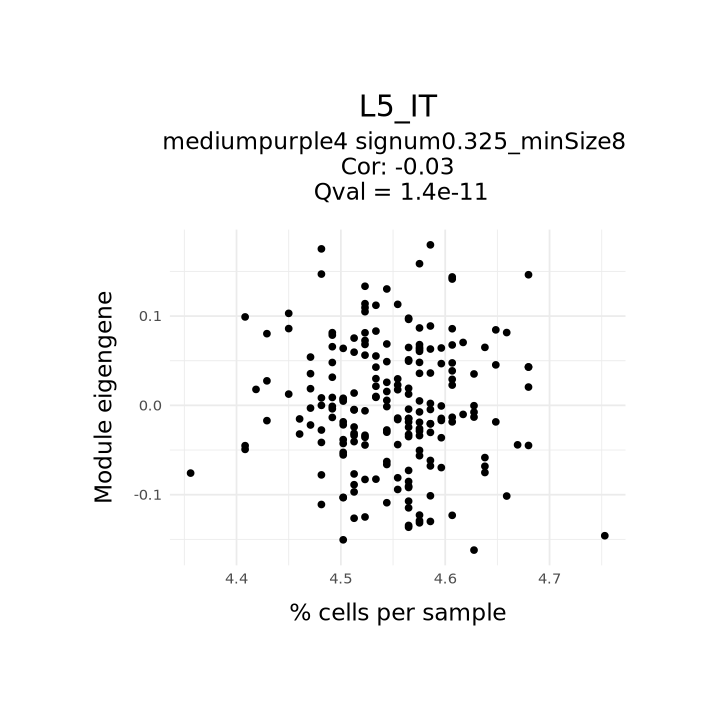

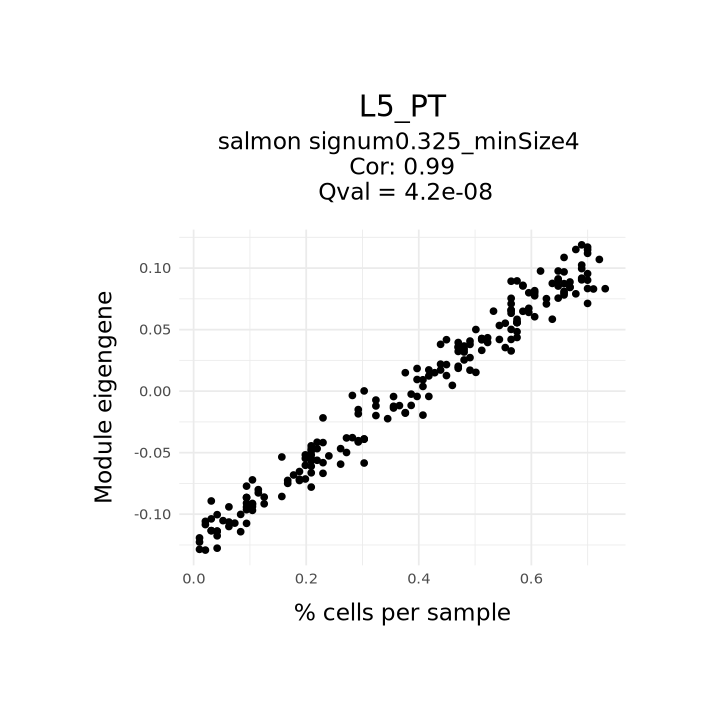

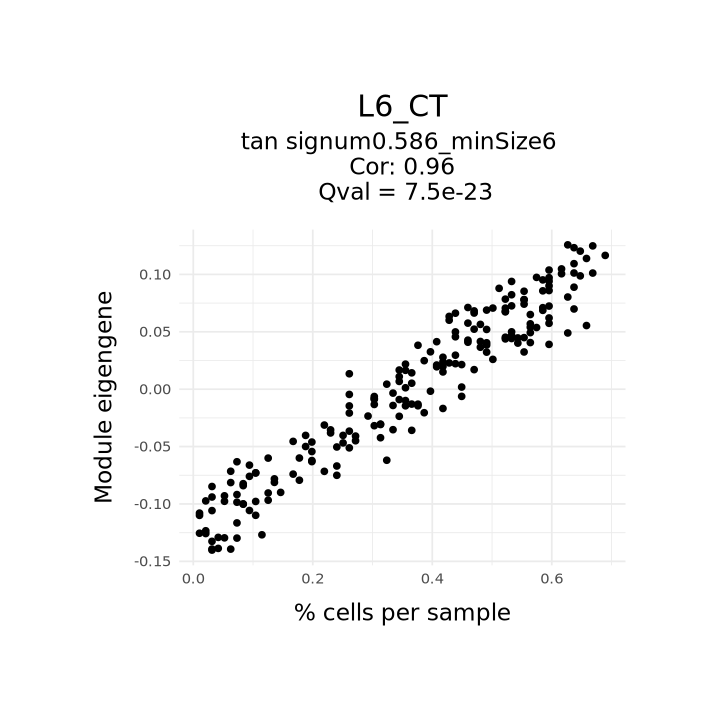

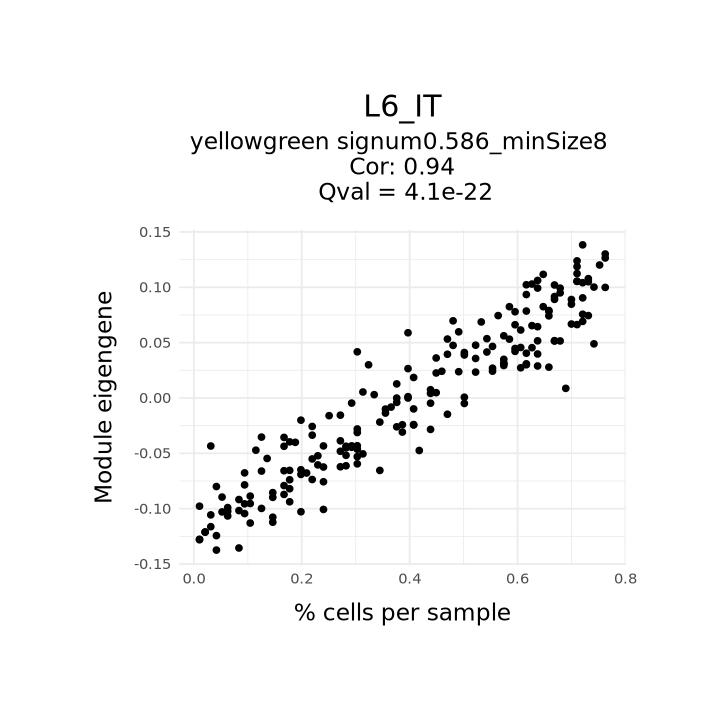

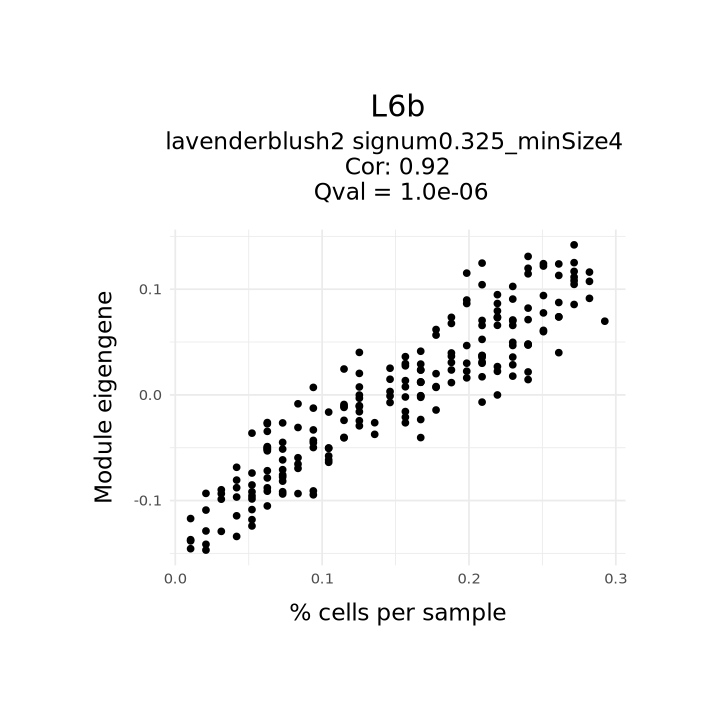

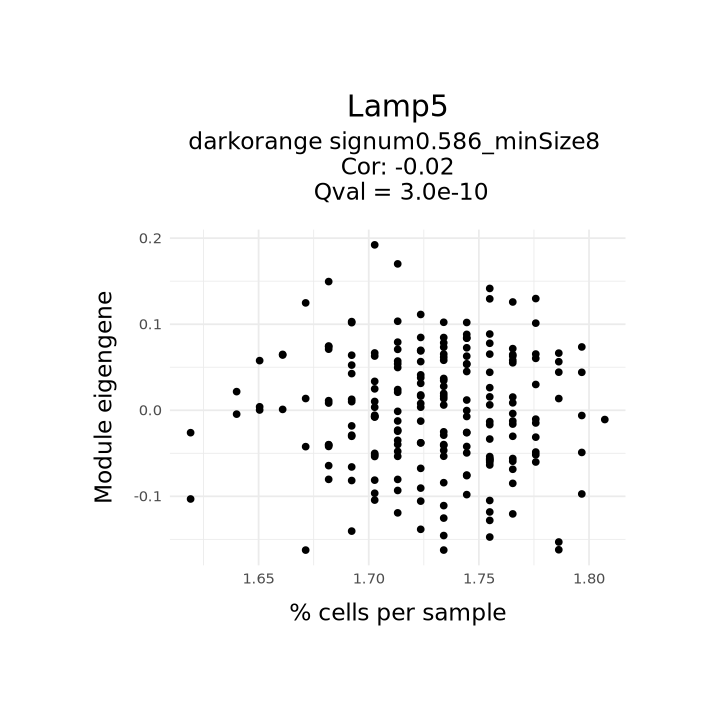

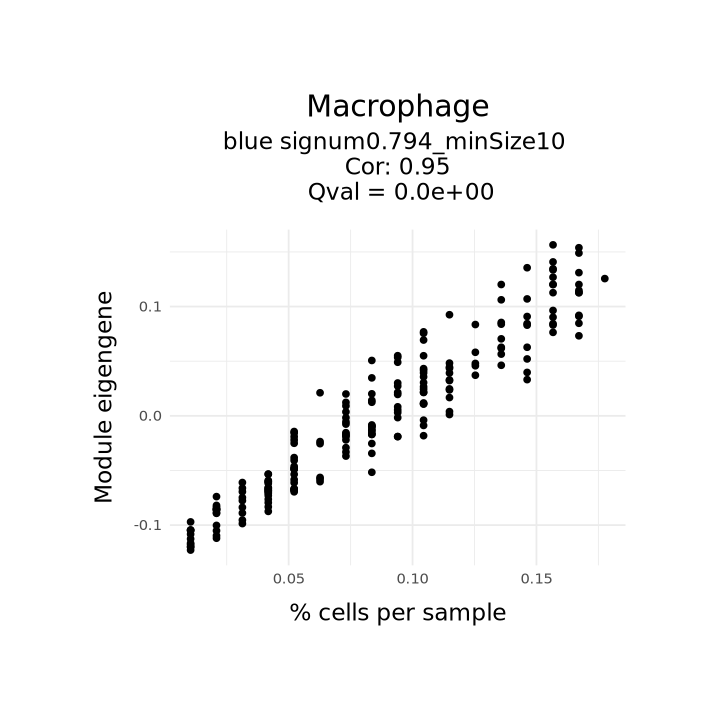

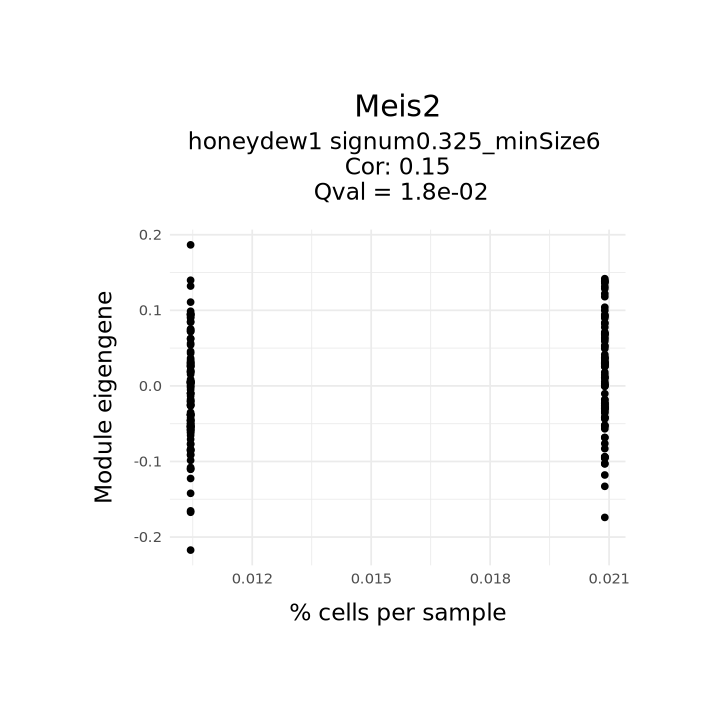

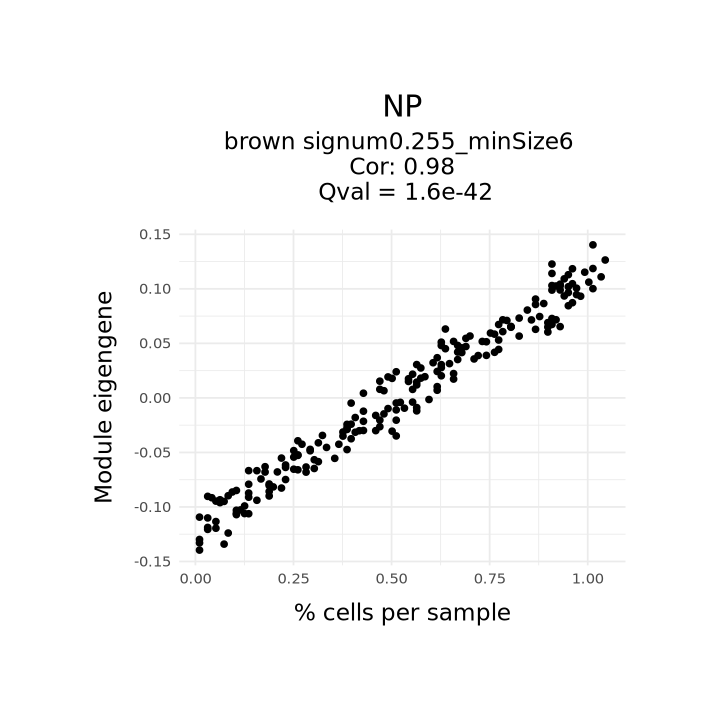

Warning message in cor(frac_per_sample, ME_vec):
“the standard deviation is zero”


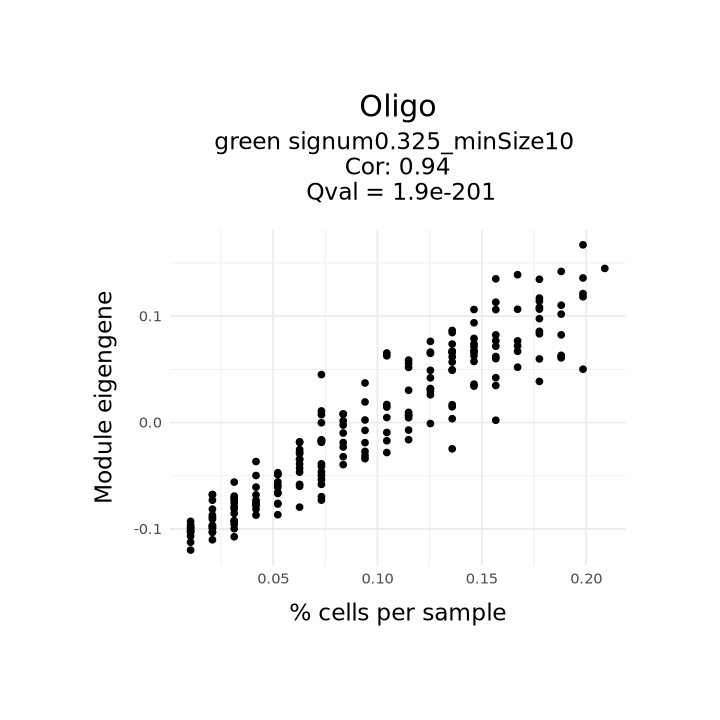

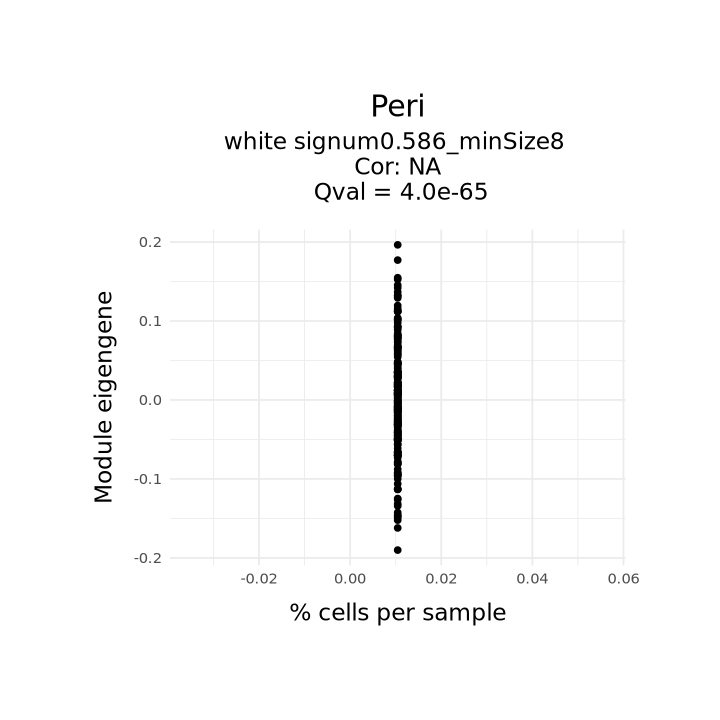

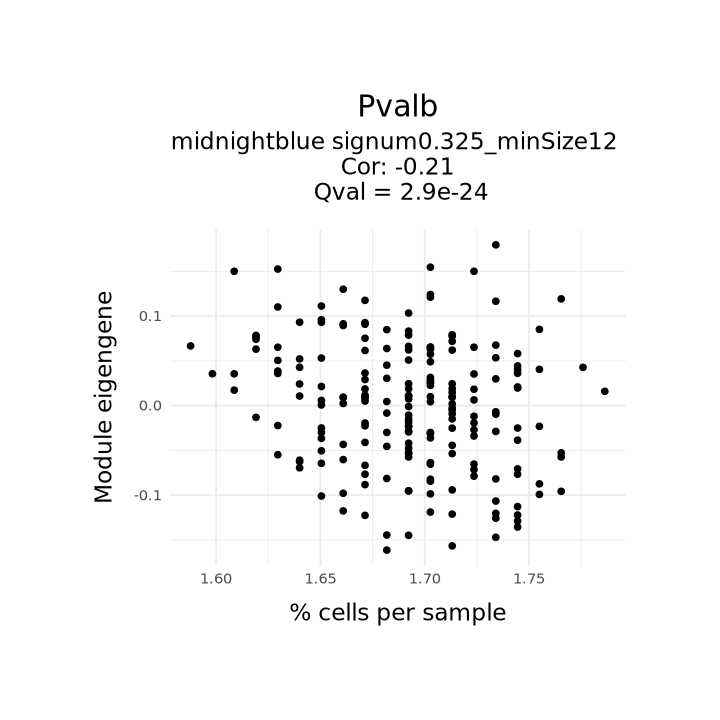

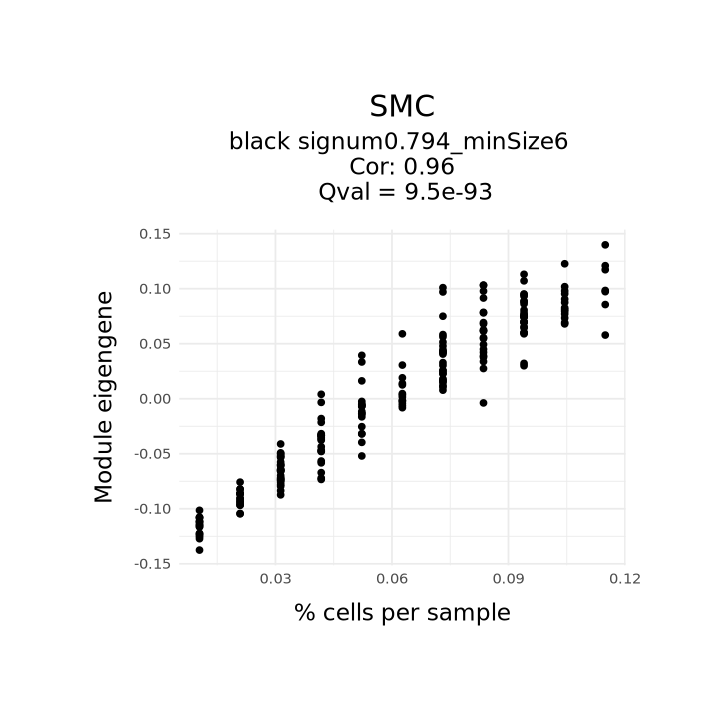

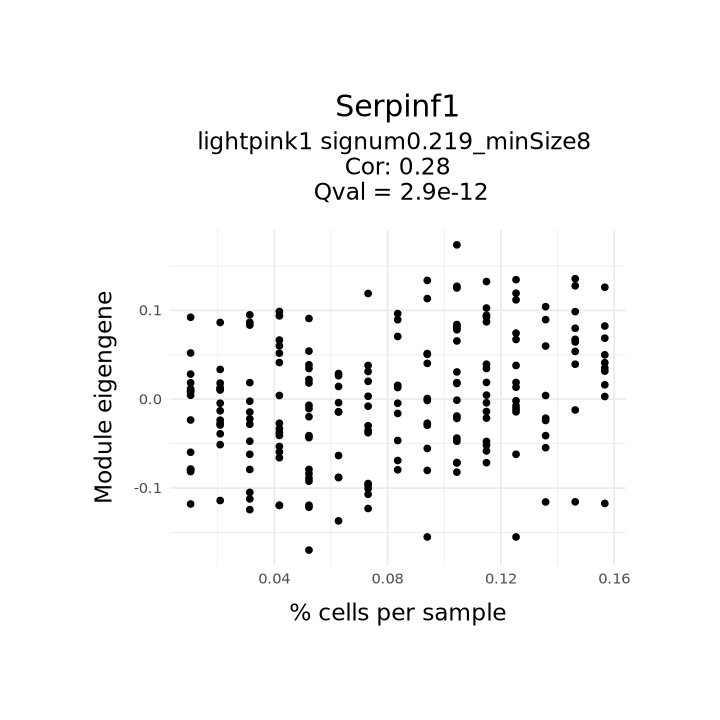

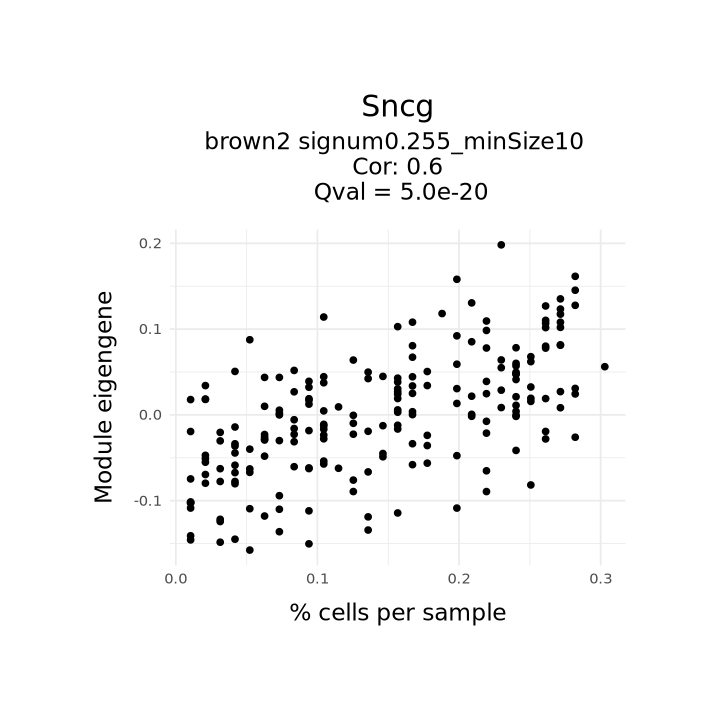

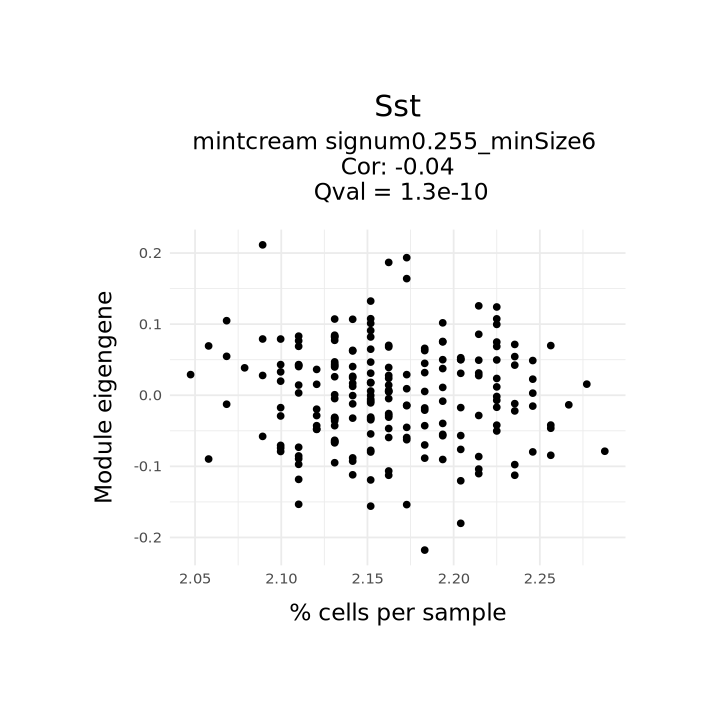

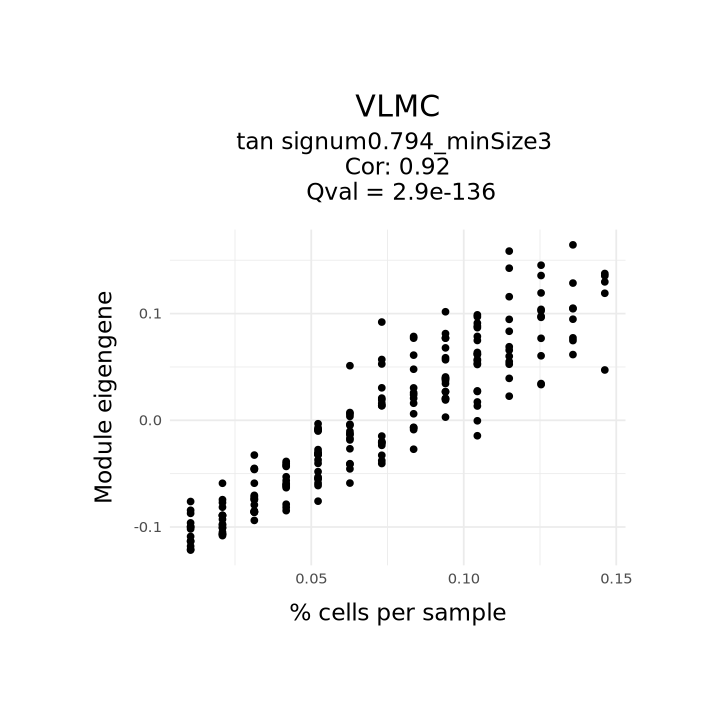

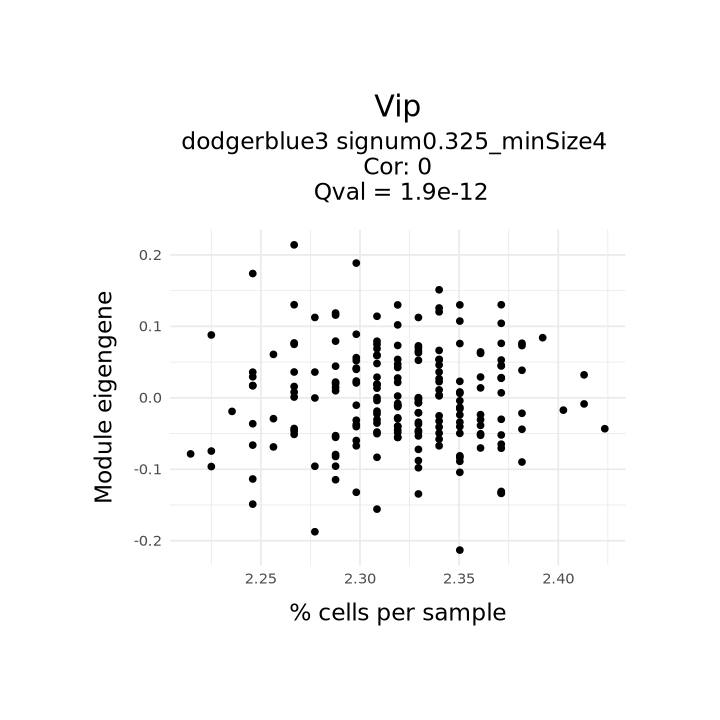

In [248]:
plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [249]:
top_corr_mods_0.4pcnt_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_0.4pcnt_PosBC_df

,Cell_type,Cor,Old_cor,Module,Old_module,Network,Old_network,Pseudobulk_SD,New_ME_path
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
orange2,Lamp5,0.1939443,-0.022435143,orange2,darkorange,Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.586_minSize8_merge_ME_0.9_20151,3.46,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151/Module_eigengenes_08-09-19.csv
gray53,Sst,0.2001982,-0.042783507,gray53,mintcream,Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.255_minSize6_merge_ME_0.9_20151,4.61,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151/Module_eigengenes_06-44-39.csv
gray58,Vip,0.2119883,-0.004228451,gray58,dodgerblue3,Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151,3.84,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151/Module_eigengenes_06-44-39.csv
orchid,CR,0.2291747,0.129101599,orchid,mistyrose1,Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151,0.50,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151/Module_eigengenes_06-18-43.csv
lightsalmon3,Pvalb,0.2500620,-0.213812093,lightsalmon3,midnightblue,Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.325_minSize12_merge_ME_0.9_20151,3.74,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151/Module_eigengenes_08-09-19.csv
gray4,Meis2,0.2845981,0.149229893,gray4,honeydew1,Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.325_minSize6_merge_ME_0.9_20151,0.50,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151/Module_eigengenes_06-44-39.csv
darkkhaki,L5_IT,0.2855019,-0.034604339,darkkhaki,mediumpurple4,Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.325_minSize8_merge_ME_0.9_20151,5.73,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151/Module_eigengenes_06-44-39.csv
dodgerblue1,Serpinf1,0.7316211,0.276181507,dodgerblue1,lightpink1,Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.219_minSize8_merge_ME_0.9_20151,4.20,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151/Module_eigengenes_08-09-19.csv
darkorchid2,Sncg,0.8643323,0.598679043,darkorchid2,brown2,Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.255_minSize10_merge_ME_0.9_20151,8.13,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151/Module_eigengenes_06-18-43.csv


# Round 4 (50% var network; PosBC module definition)

In [250]:
network_dir <- "tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_30pcntCells_50pcntVar_200samples_legend_05-16-36.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_30pcntCells_50pcntVar_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

In [251]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [252]:
top_corr_mods_50pcnt_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_50pcnt_PosBC_df

,Cell_type,Cor,Old_cor,Module,Old_module,Network,Old_network,Pseudobulk_SD,New_ME_path
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
pink1,Sncg,0.1320302,0.08311361,pink1,lightcyan,Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.629_minSize6_merge_ME_0.9_20151,10.18,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151/Module_eigengenes_07-51-01.csv
skyblue2,CR,0.1490367,-0.04376170,skyblue2,peru,Bicor-None_signum0.629_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151,0.79,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.629_minSize4_merge_ME_0.9_20151/Module_eigengenes_07-17-00.csv
orange1,Meis2,0.1785107,-0.08011696,orange1,antiquewhite4,Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.629_minSize8_merge_ME_0.9_20151,0.74,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151/Module_eigengenes_08-57-01.csv
palevioletred4,Peri,0.1873673,-0.16100388,palevioletred4,blue,Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.968_minSize3_merge_ME_0.9_20151,0.73,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151/Module_eigengenes_07-51-01.csv
lightgoldenrod4,Serpinf1,0.1938398,0.07748015,lightgoldenrod4,salmon,Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151,5.23,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151/Module_eigengenes_07-51-01.csv
mintcream,L4,0.2015220,0.07698462,mintcream,lightpink3,Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.465_minSize10_merge_ME_0.9_20151,0.70,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151/Module_eigengenes_08-57-01.csv
mistyrose1,L6_IT,0.7960936,0.69452226,mistyrose1,darkorange2,Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.842_minSize3_merge_ME_0.9_20151,25.63,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151/Module_eigengenes_08-57-01.csv
darkolivegreen,VLMC,0.8453615,0.83210083,darkolivegreen,orange,Bicor-None_signum0.629_minSize10_merge_ME_0.9_20151,Bicor-None_signum0.629_minSize8_merge_ME_0.9_20151,5.17,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.629_minSize10_merge_ME_0.9_20151/Module_eigengenes_07-48-32.csv
darkorange,Oligo,0.8554086,0.82541326,darkorange,darkturquoise,Bicor-None_signum0.842_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.928_minSize3_merge_ME_0.9_20151,7.05,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.842_minSize3_merge_ME_0.9_20151/Module_eigengenes_07-08-21.csv


In [253]:
# plot_ctype_abundance(pseudobulk_legend)

# Round 5 (50% var network; PosFDR module definition)

In [254]:
# network_dir <- "tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules"

# pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_30pcntCells_50pcntVar_200samples_legend_05-16-36.csv")
# pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
# pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

# top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_30pcntCells_50pcntVar_200samples_log2_pseudobulk_PosFDR_top_Qval_modules.csv")

In [255]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [256]:
# top_corr_mods_50pcnt_PosFDR_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
# top_corr_mods_50pcnt_PosFDR_df

# Round 6 (10% var network, PosFDR module definition)

In [257]:
# network_dir <- "tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules"

# pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_10pcntVar_200samples_legend_11-31-12.csv")
# pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
# pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

# top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_10pcntVar_200samples_log2_pseudobulk_PosFDR_top_Qval_modules.csv")

In [258]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [259]:
# top_corr_mods_10pcnt_PosFDR_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
# top_corr_mods_10pcnt_PosFDR_df

# Round 7 (10% var network, PosBC module definition)

In [260]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_10pcntVar_200samples_legend_11-31-12.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_10pcntVar_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

In [261]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [262]:
top_corr_mods_10pcnt_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_10pcnt_PosBC_df

,Cell_type,Cor,Old_cor,Module,Old_module,Network,Old_network,Pseudobulk_SD,New_ME_path
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
rosybrown3,VLMC,0.2176395,0.09400113,rosybrown3,darkslateblue,Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.539_minSize4_merge_ME_0.9_20151,1.24,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151/Module_eigengenes_08-11-49.csv
yellow1,Serpinf1,0.2191469,0.04851468,yellow1,floralwhite,Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.349_minSize4_merge_ME_0.9_20151,1.60,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151/Module_eigengenes_06-09-50.csv
greenyellow,Meis2,0.2200408,0.02326452,greenyellow,antiquewhite,Bicor-None_signum0.349_minSize10_merge_ME_0.9_20151,Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151,0.50,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.349_minSize10_merge_ME_0.9_20151/Module_eigengenes_06-51-46.csv
lightgoldenrod4,Sncg,0.2376732,0.11588496,lightgoldenrod4,orangered4,Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.349_minSize6_merge_ME_0.9_20151,2.37,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151/Module_eigengenes_08-11-49.csv
steelblue3,CR,0.2723505,0.12232763,steelblue3,gray2,Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151,0.50,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151/Module_eigengenes_08-11-49.csv
plum2,Oligo,0.3083297,0.10097966,plum2,grey60,Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.539_minSize6_merge_ME_0.9_20151,1.61,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151/Module_eigengenes_06-09-50.csv
royalblue,SMC,0.3581447,0.35386647,royalblue,purple,Bicor-None_signum0.705_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.539_minSize3_merge_ME_0.9_20151,1.14,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.705_minSize3_merge_ME_0.9_20151/Module_eigengenes_05-57-34.csv
magenta3,L6_IT,0.3912662,0.37324554,magenta3,hotpink3,Bicor-None_signum0.539_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.349_minSize4_merge_ME_0.9_20151,4.70,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.539_minSize3_merge_ME_0.9_20151/Module_eigengenes_06-00-38.csv
palevioletred4,L6_CT,0.4346011,0.42529993,palevioletred4,gray15,Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.173_minSize5_merge_ME_0.9_20151,3.86,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151/Module_eigengenes_06-09-50.csv


# Round 8 (kappa = 25 network, PosBC module definition)

In [263]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_25kappa_200samples_legend_08-10-34.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_25kappa_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

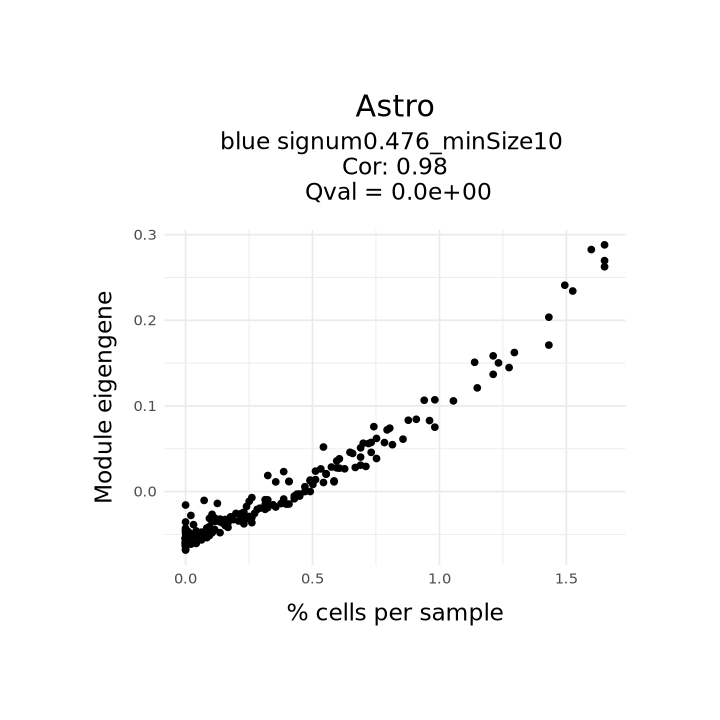

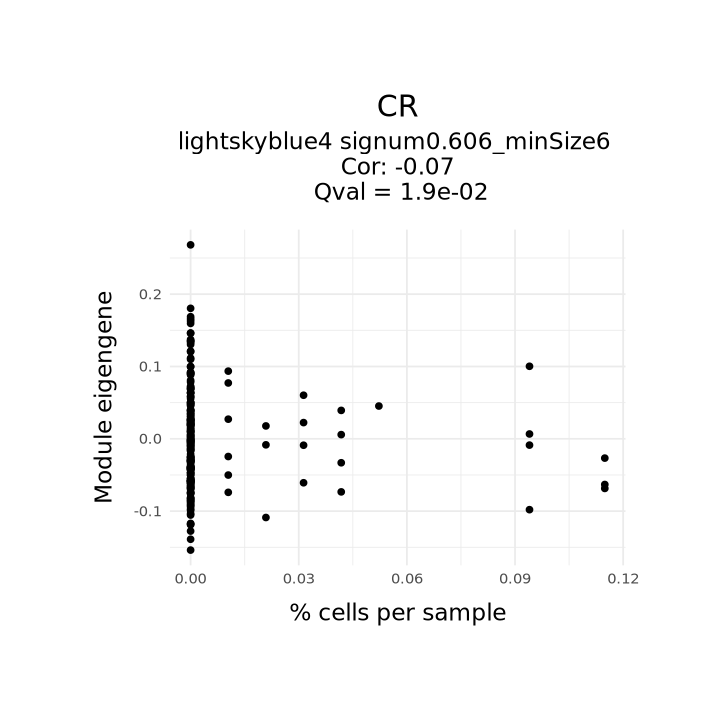

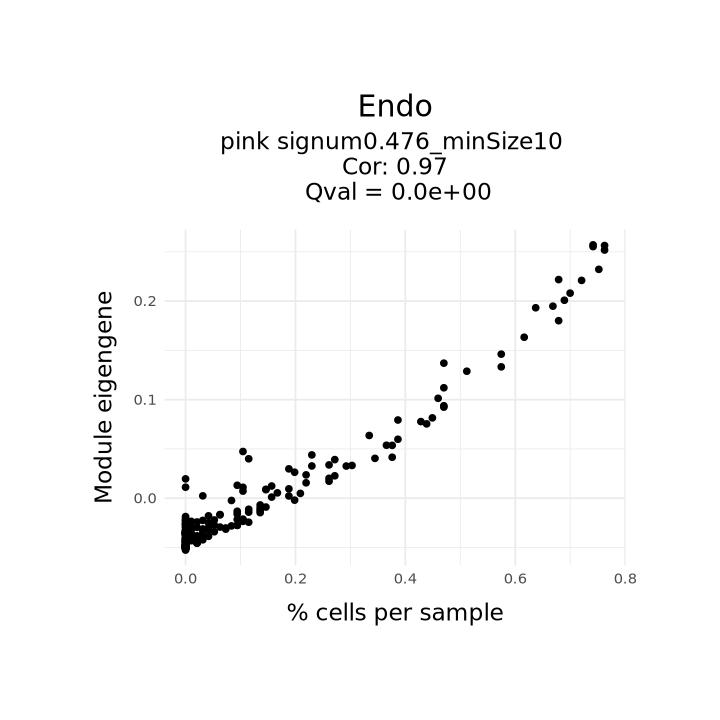

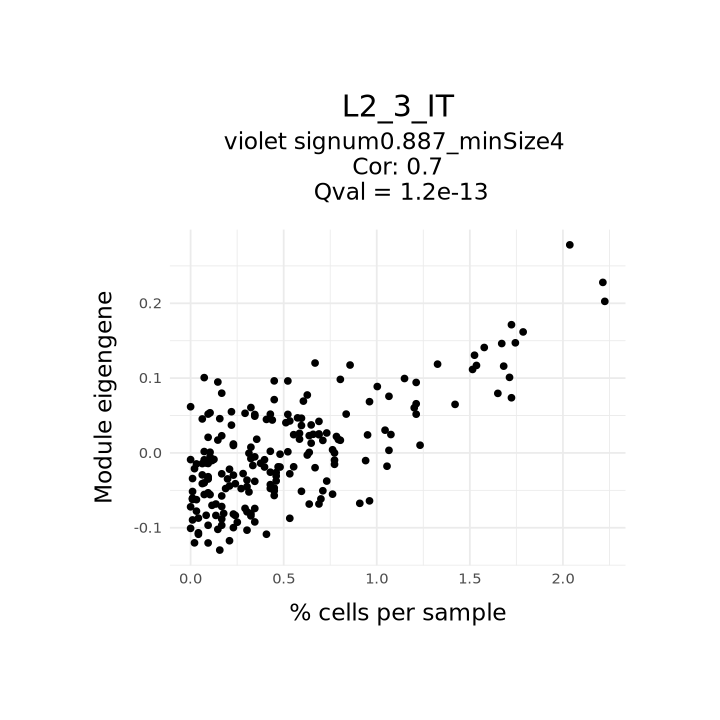

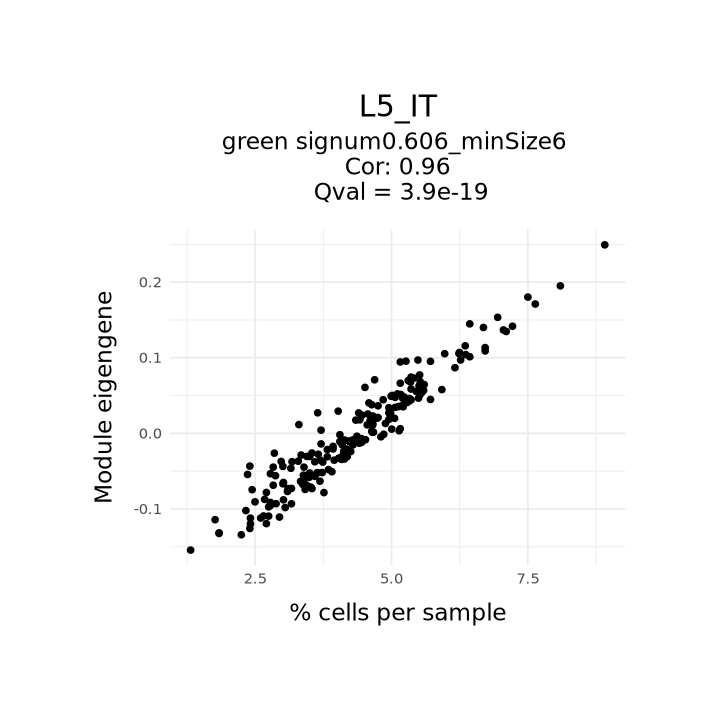

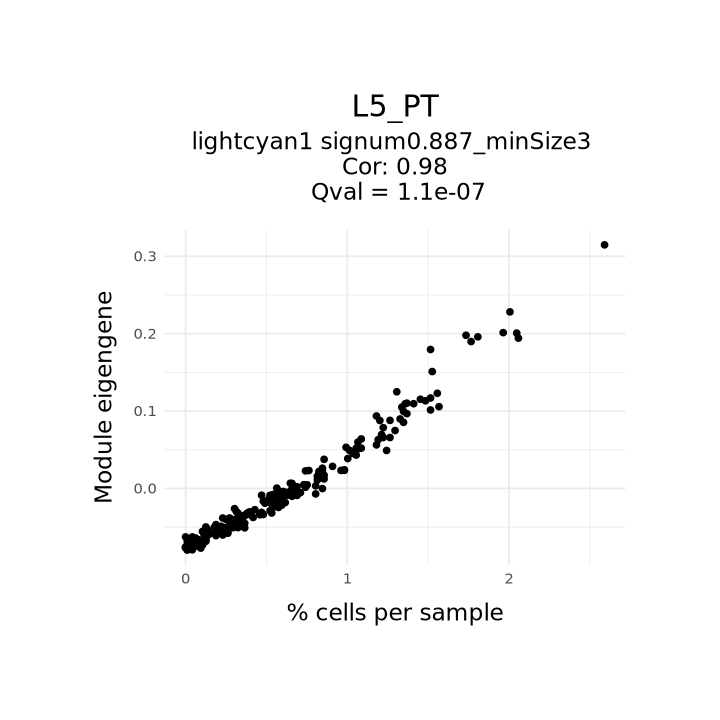

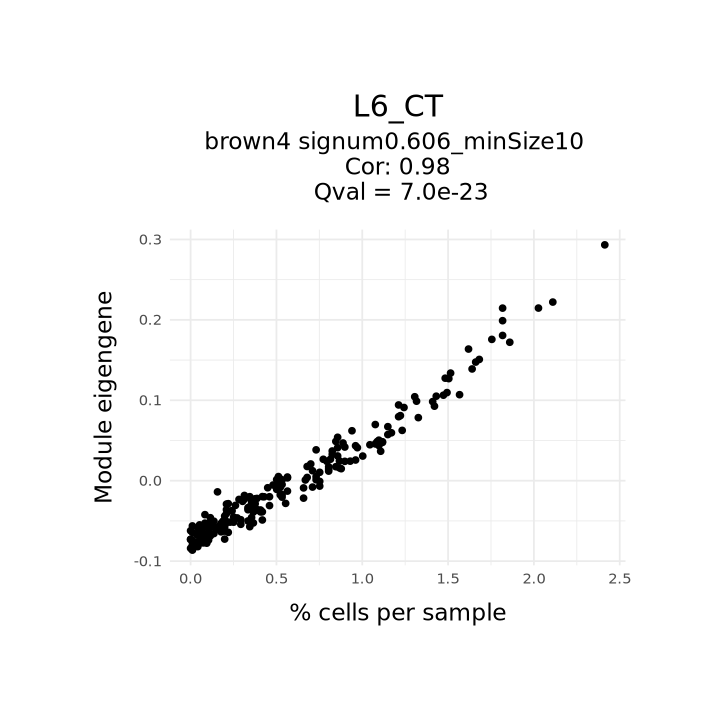

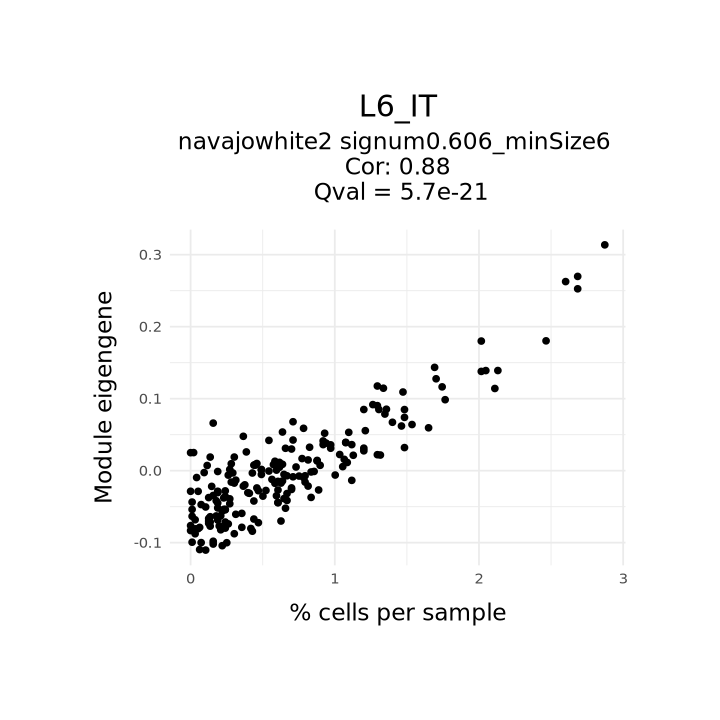

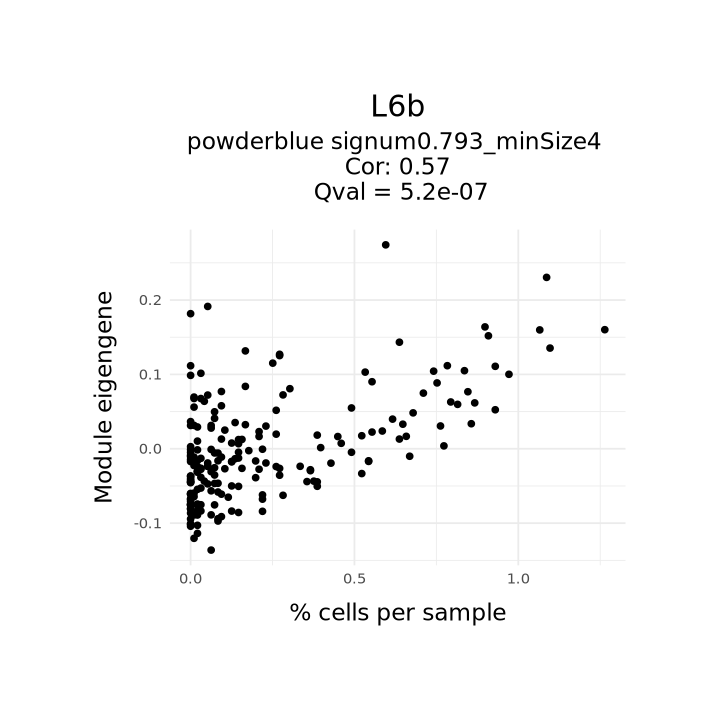

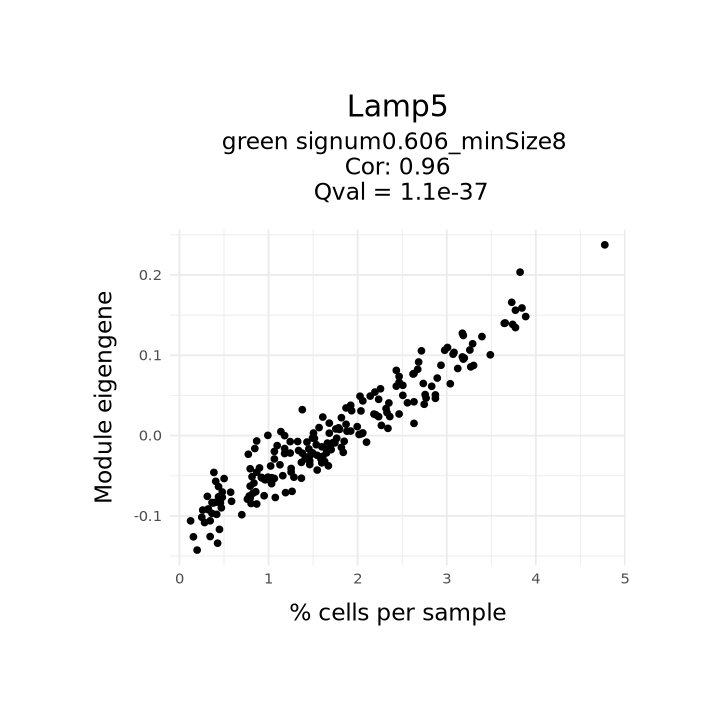

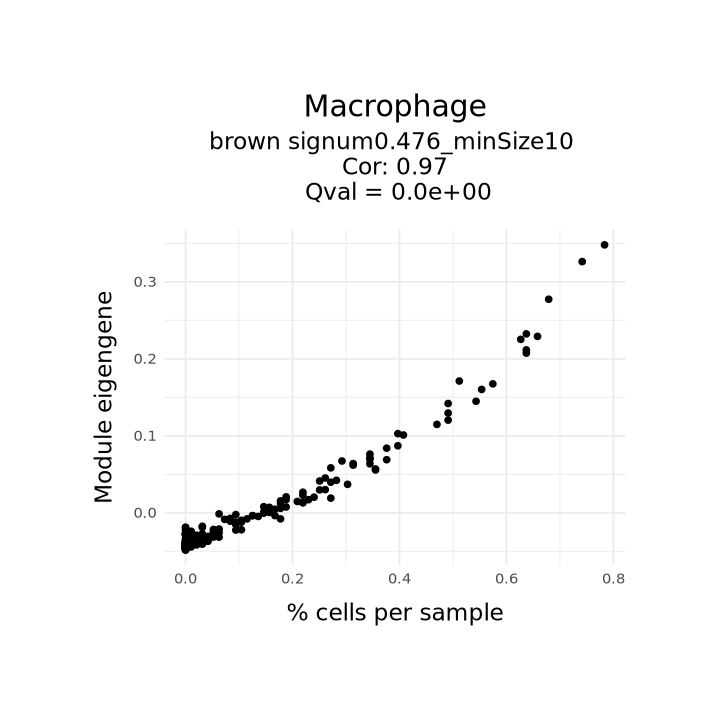

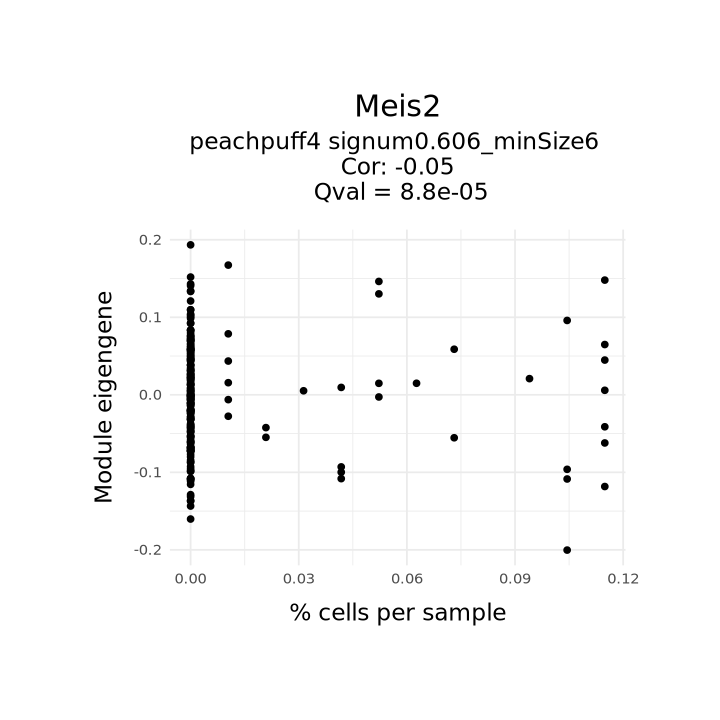

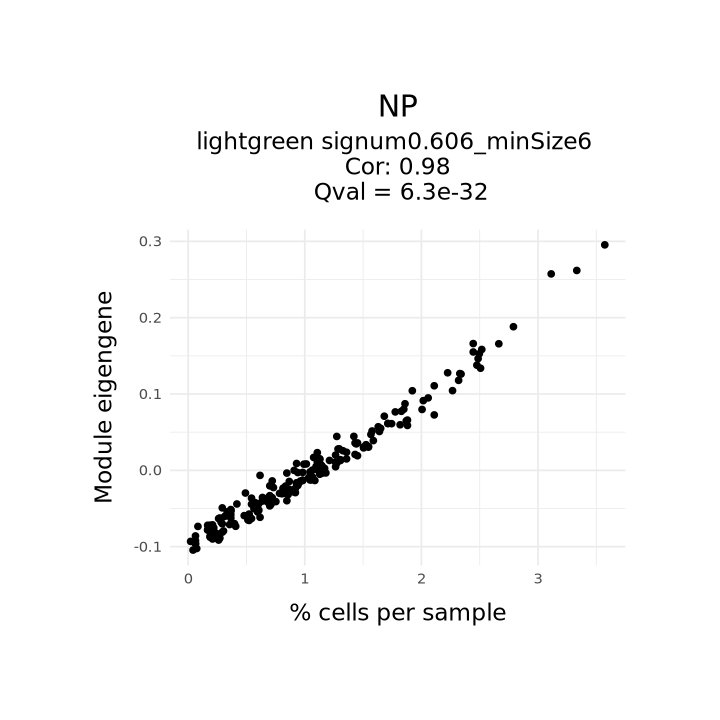

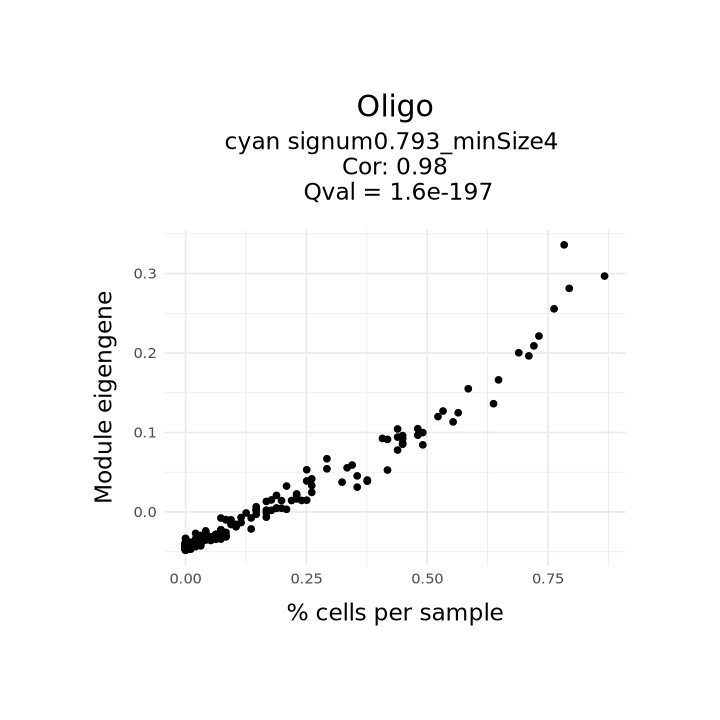

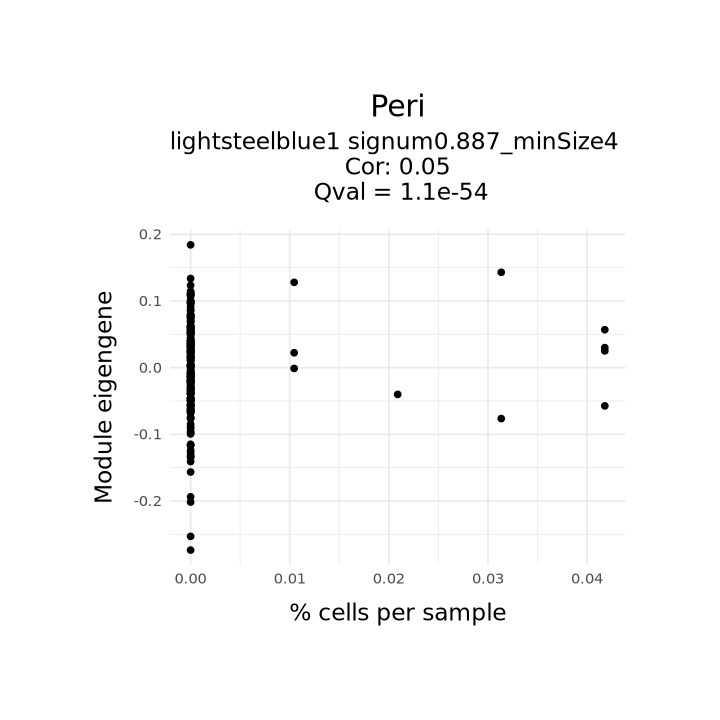

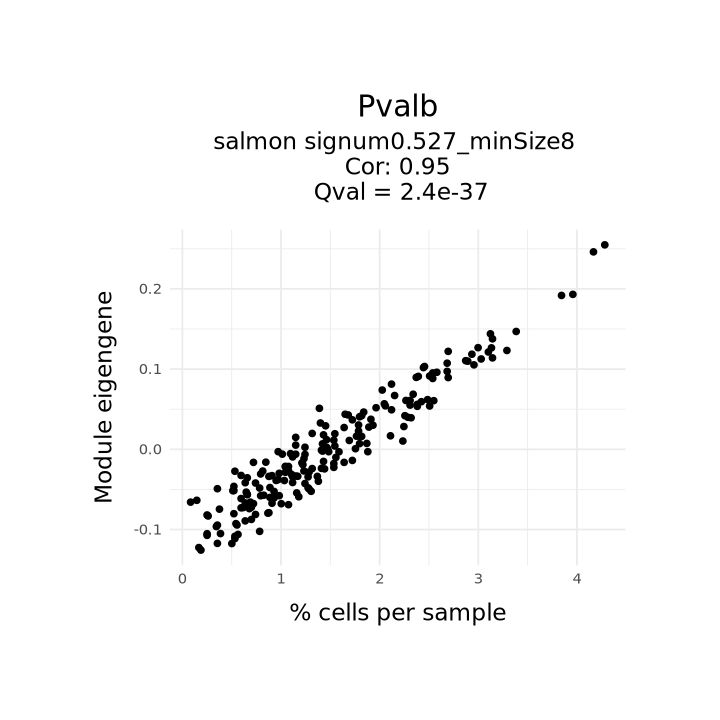

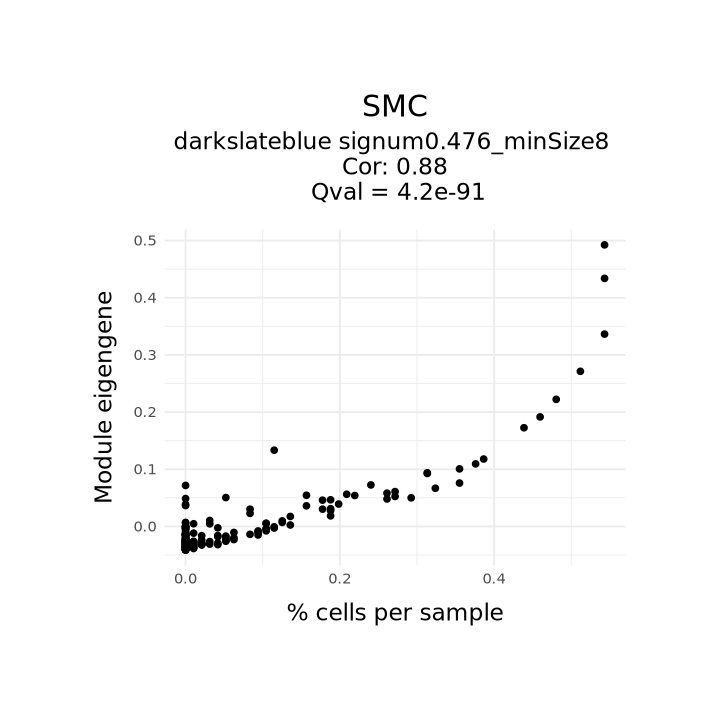

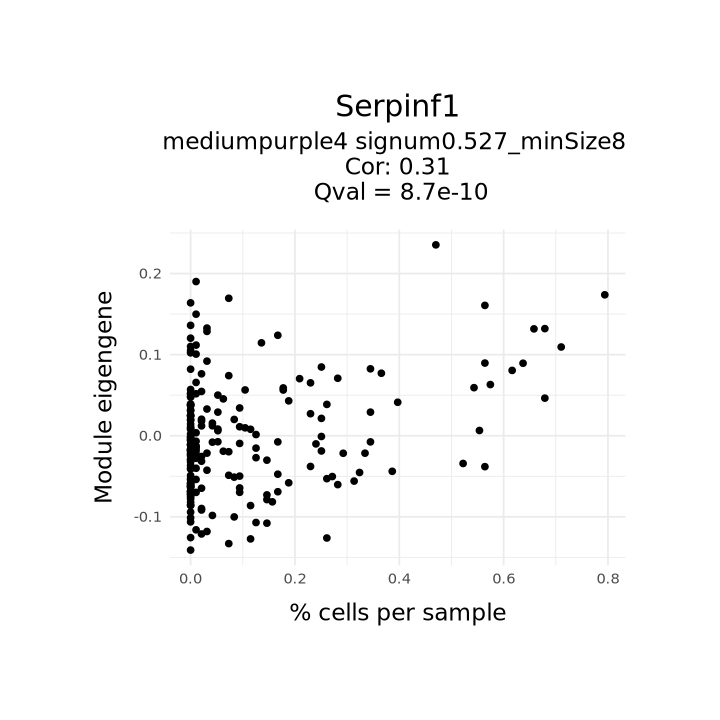

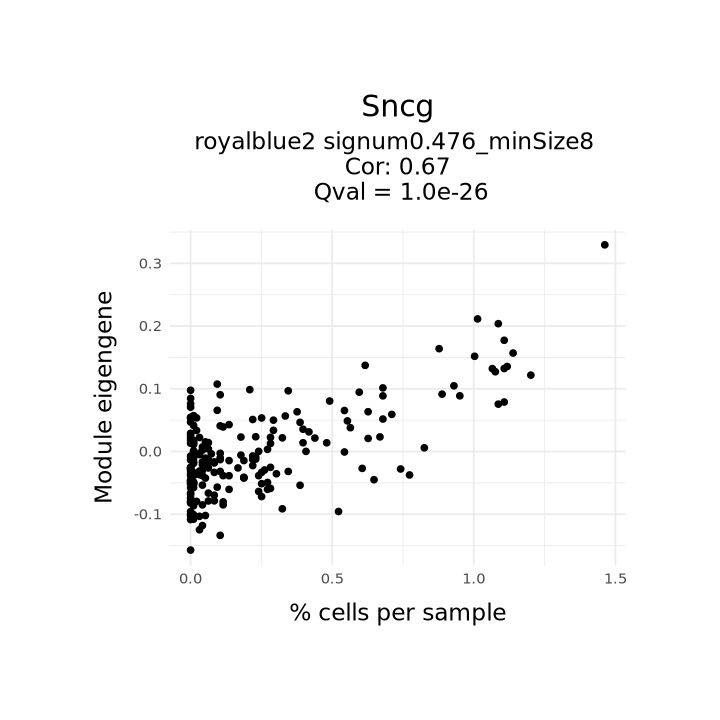

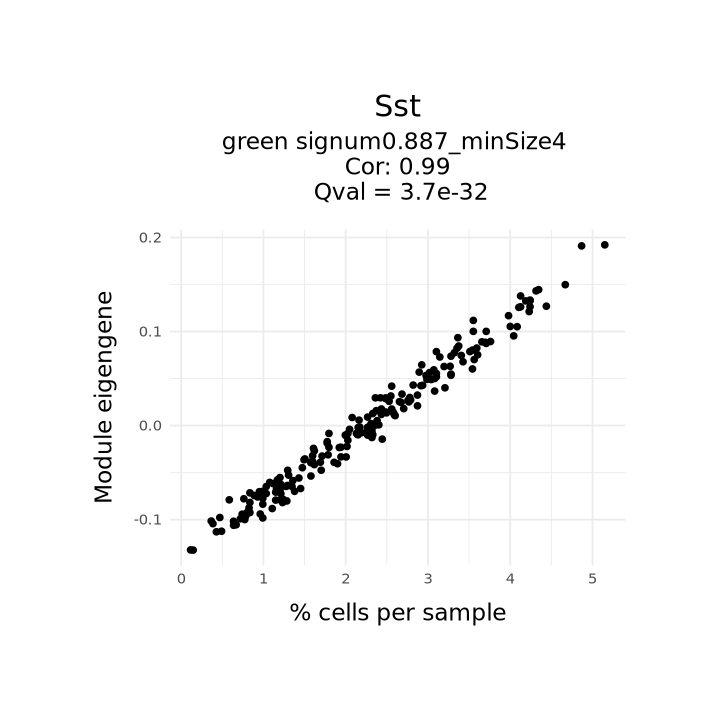

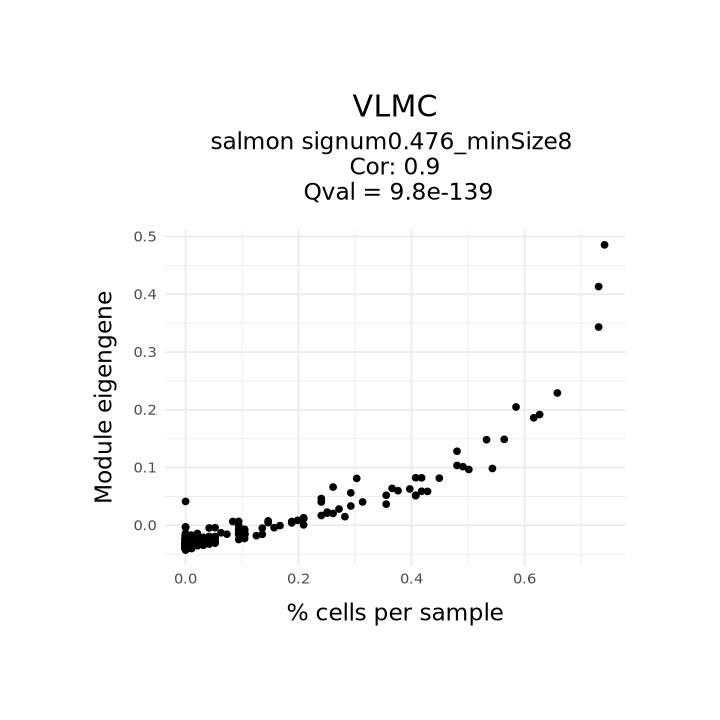

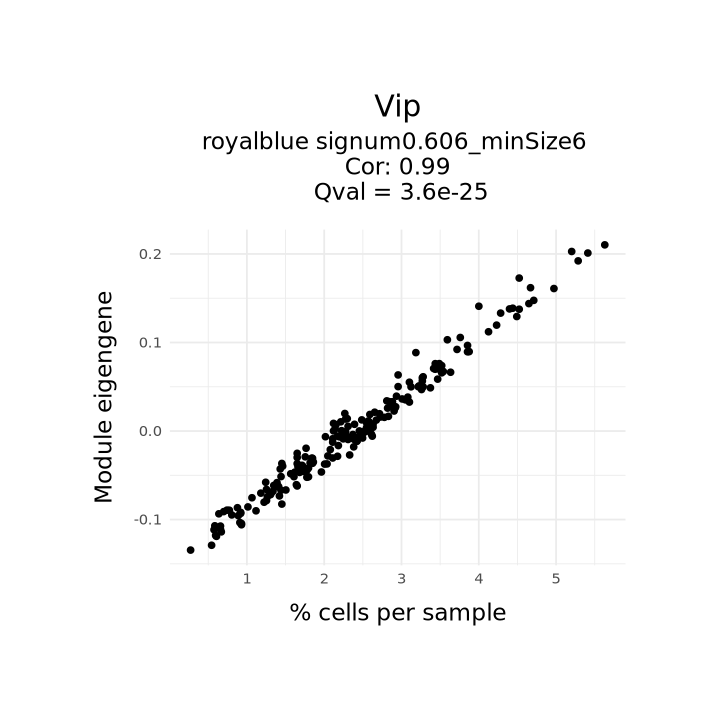

In [264]:
plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [265]:
top_corr_mods_25kappa_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_25kappa_PosBC_df

,Cell_type,Cor,Old_cor,Module,Old_module,Network,Old_network,Pseudobulk_SD,New_ME_path
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
navajowhite1,Peri,0.1932410,0.05267446,navajowhite,lightsteelblue1,Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.887_minSize4_merge_ME_0.9_20151,0.65,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151/Module_eigengenes_10-40-41.csv
firebrick1,CR,0.2303541,-0.06763805,firebrick1,lightskyblue4,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,1.96,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151/Module_eigengenes_10-58-48.csv
brown3,Meis2,0.3125991,-0.05137787,brown3,peachpuff4,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,2.71,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151/Module_eigengenes_10-58-48.csv
honeydew,Serpinf1,0.4026167,0.30979272,honeydew,mediumpurple4,Bicor-None_signum0.887_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.527_minSize8_merge_ME_0.9_20151,16.64,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.887_minSize3_merge_ME_0.9_20151/Module_eigengenes_10-31-35.csv
powderblue,L6b,0.5722537,0.57225369,powderblue,powderblue,Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151,27.72,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151/Module_eigengenes_10-40-41.csv
firebrick11,Sncg,0.6889803,0.66953336,firebrick1,royalblue2,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151,30.88,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151/Module_eigengenes_10-58-48.csv
darkslateblue,SMC,0.8800080,0.88000800,darkslateblue,darkslateblue,Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151,Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151,11.55,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151/Module_eigengenes_11-56-44.csv
ivory,L6_IT,0.9108326,0.87961021,ivory,navajowhite2,Bicor-None_signum0.793_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,56.24,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.793_minSize5_merge_ME_0.9_20151/Module_eigengenes_10-47-45.csv
palevioletred3,VLMC,0.9117353,0.90136592,palevioletred3,salmon,Bicor-None_signum0.793_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151,16.84,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.793_minSize6_merge_ME_0.9_20151/Module_eigengenes_10-52-27.csv


# Round 9 (kappa = 25 network, PosBC module definition; merge param = 0.85)

In [266]:
# network_dir <- "tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_mergeParam0.85_Modules"

# pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_25kappa_200samples_legend_08-10-34.csv")
# pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
# pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

# top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_25kappa_200samples_log2_pseudobulk_mergeParam0.85_PosBC_top_Qval_modules.csv")

In [267]:
# top_corr_mods_25kappa_merge0.85_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
# top_corr_mods_25kappa_merge0.85_PosBC_df

# Round 9 (kappa = 25 network, PosBC module definition; no log2 transform)

In [268]:
# network_dir <- "tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_pseudobulk_Modules"

# pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_25kappa_200samples_legend_08-10-34.csv")
# pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
# pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

# top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_25kappa_200samples_pseudobulk_PosBC_top_Qval_modules.csv")

In [269]:
# top_corr_mods_25kappa_nolog_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
# top_corr_mods_25kappa_nolog_PosBC_df

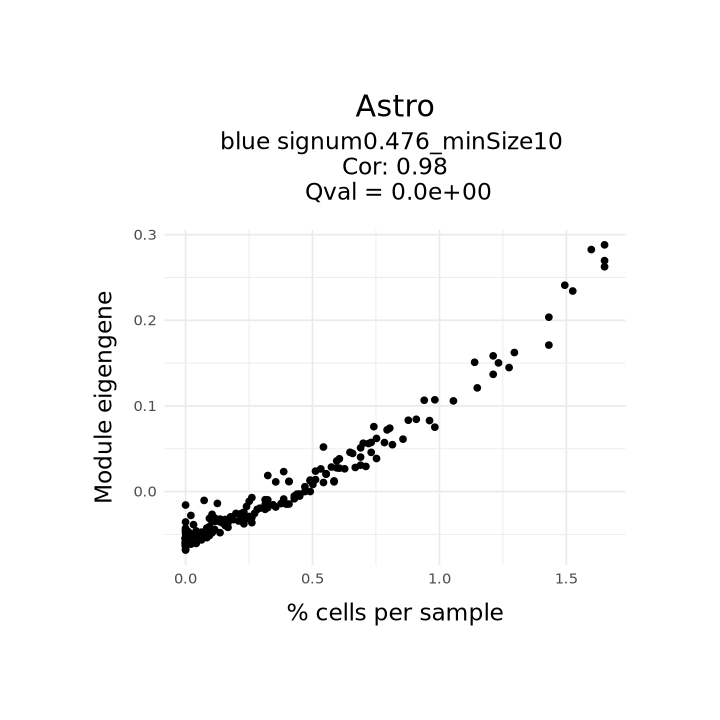

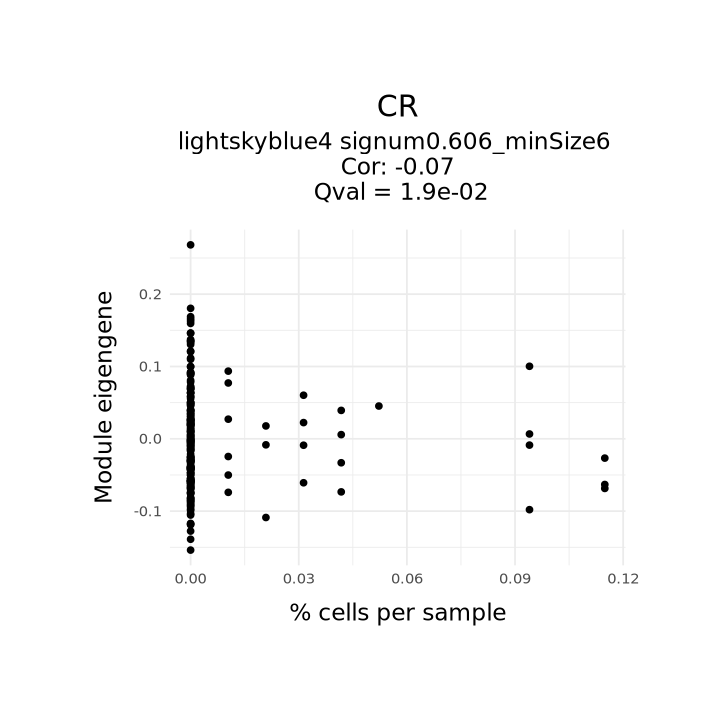

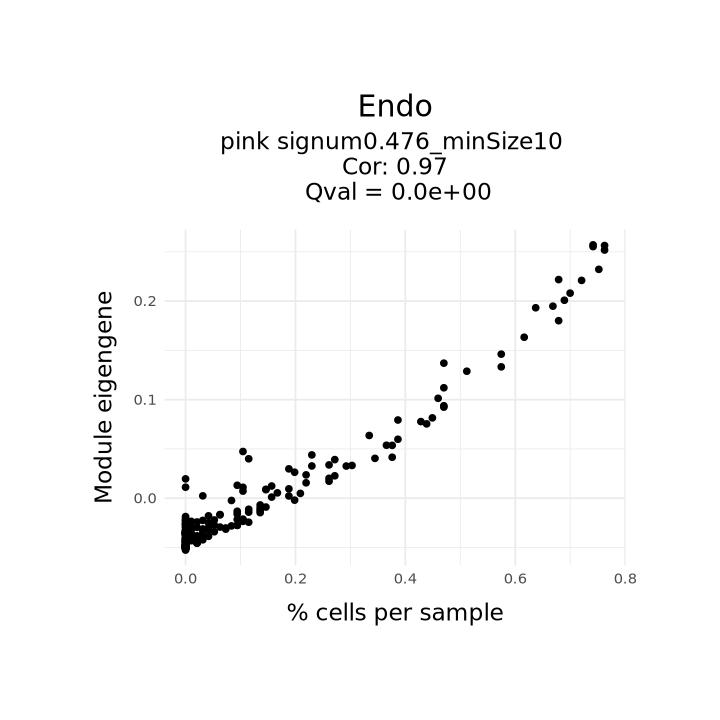

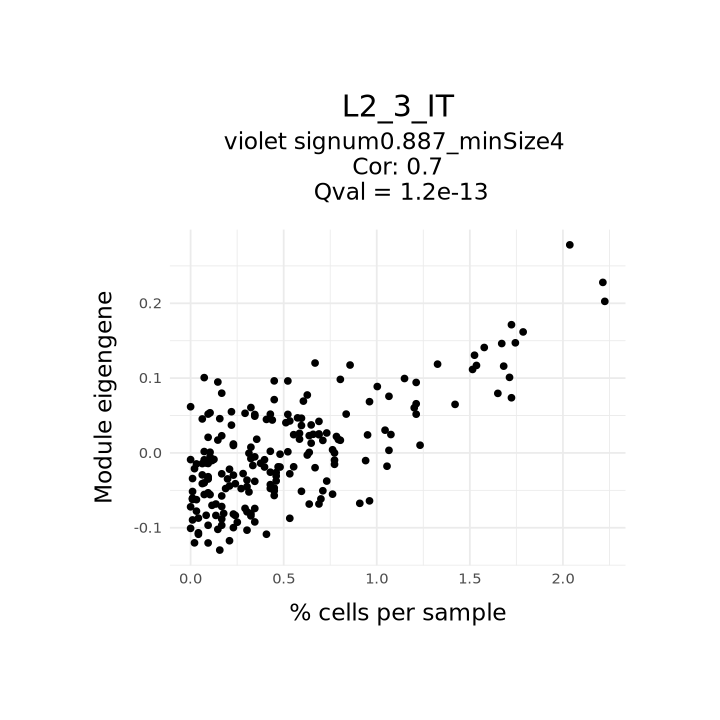

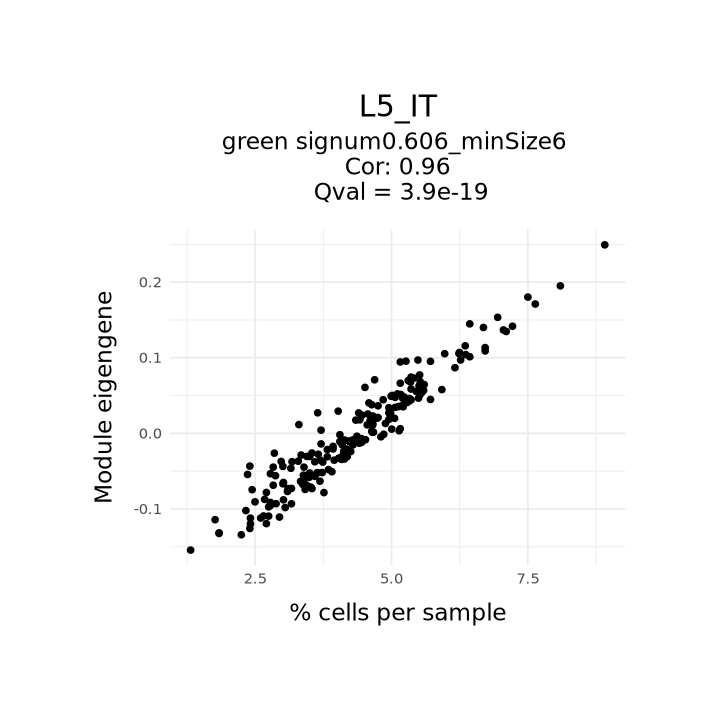

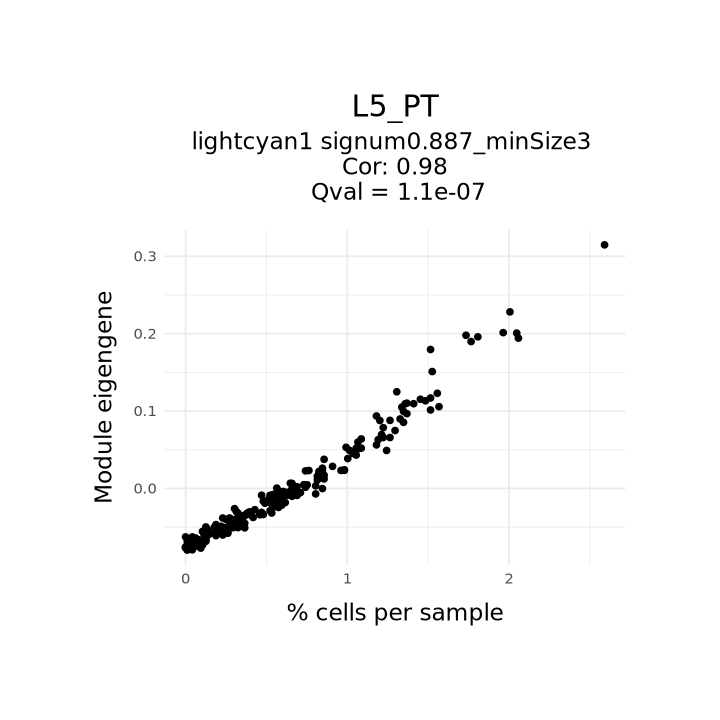

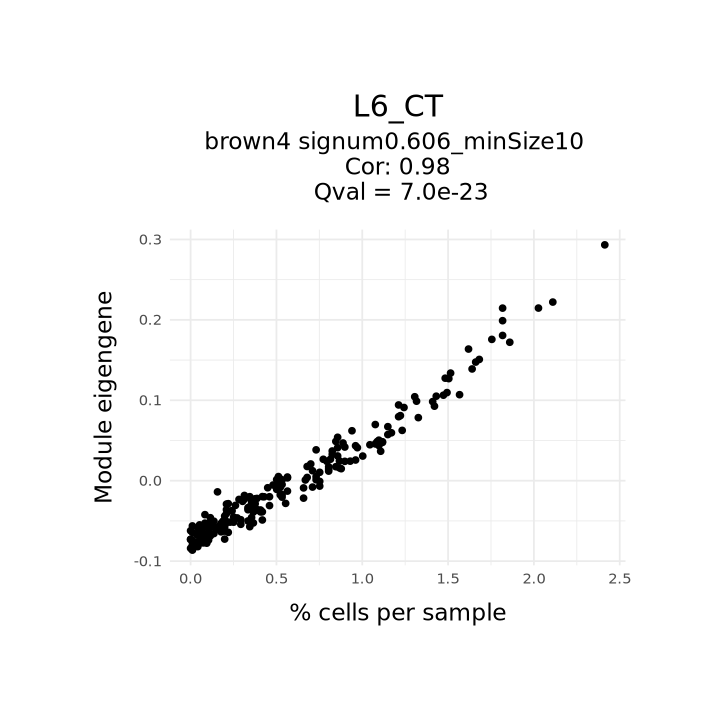

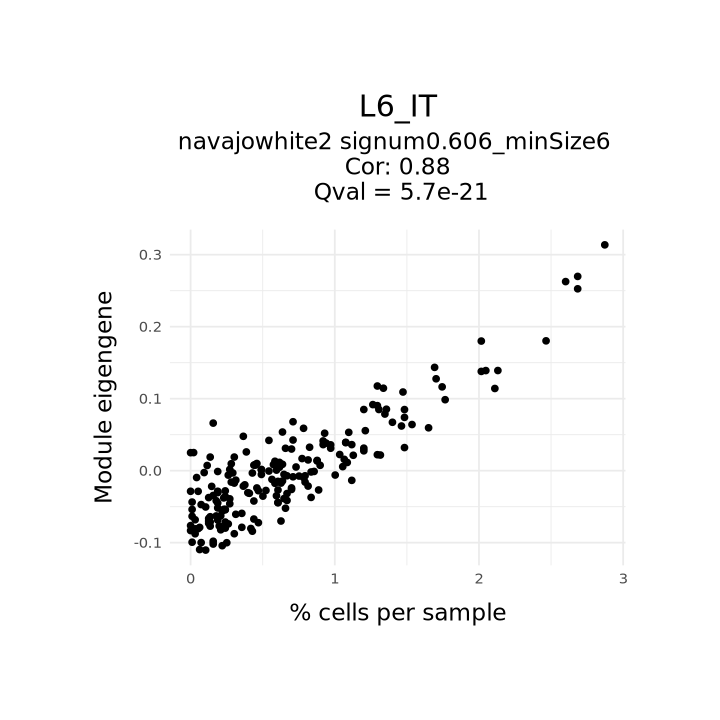

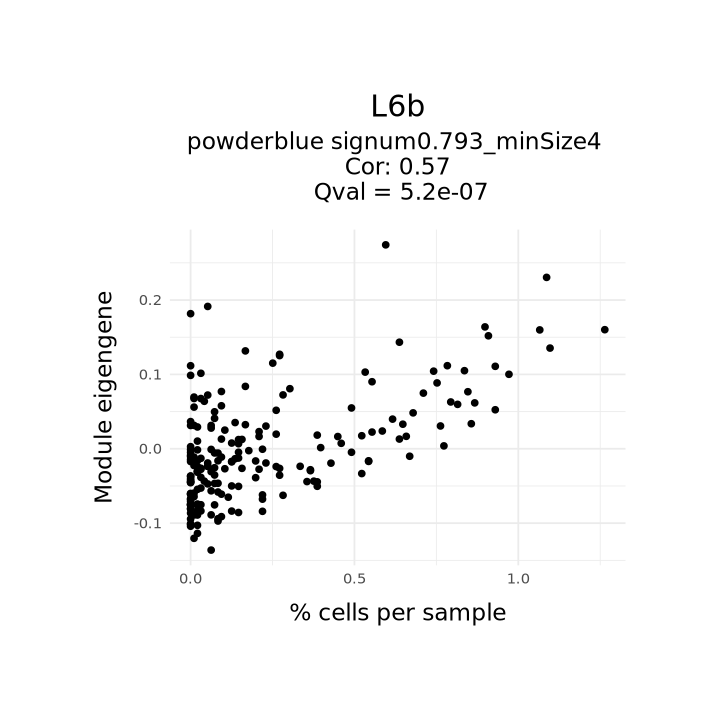

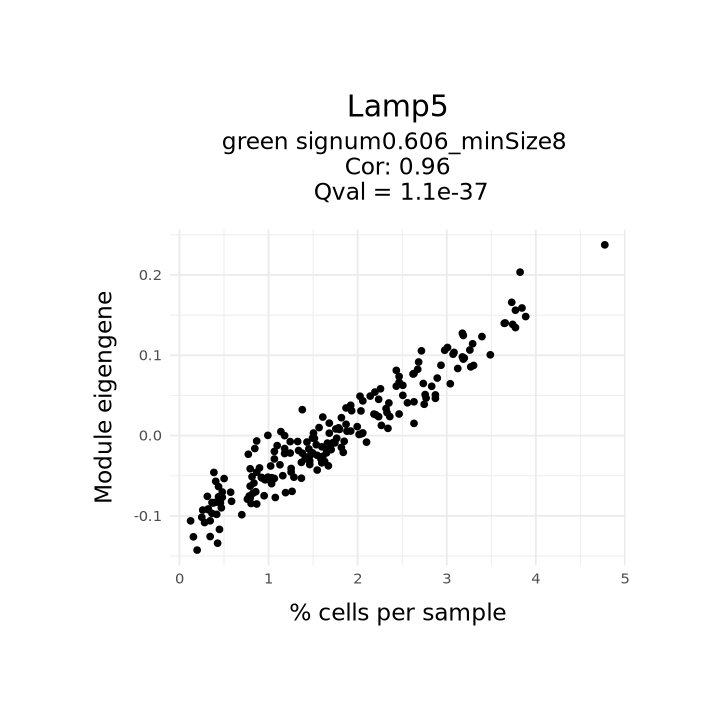

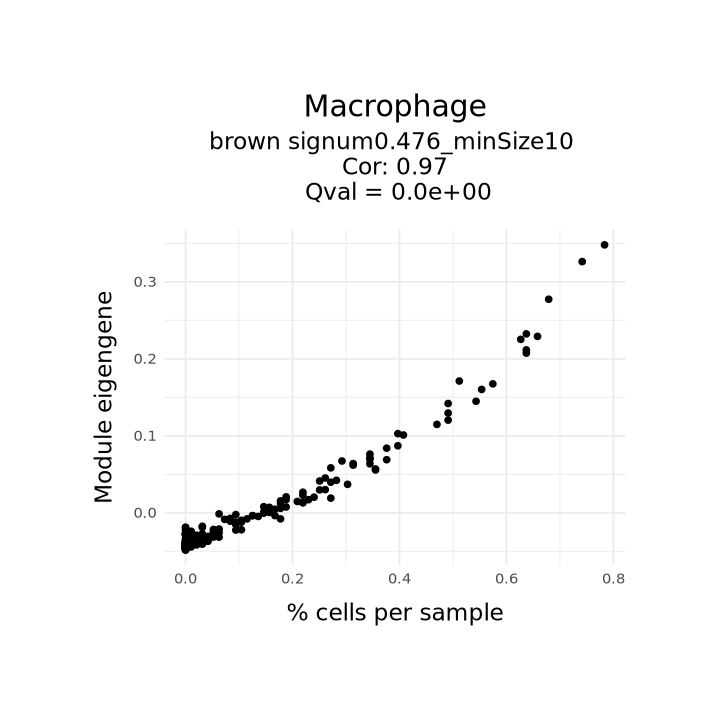

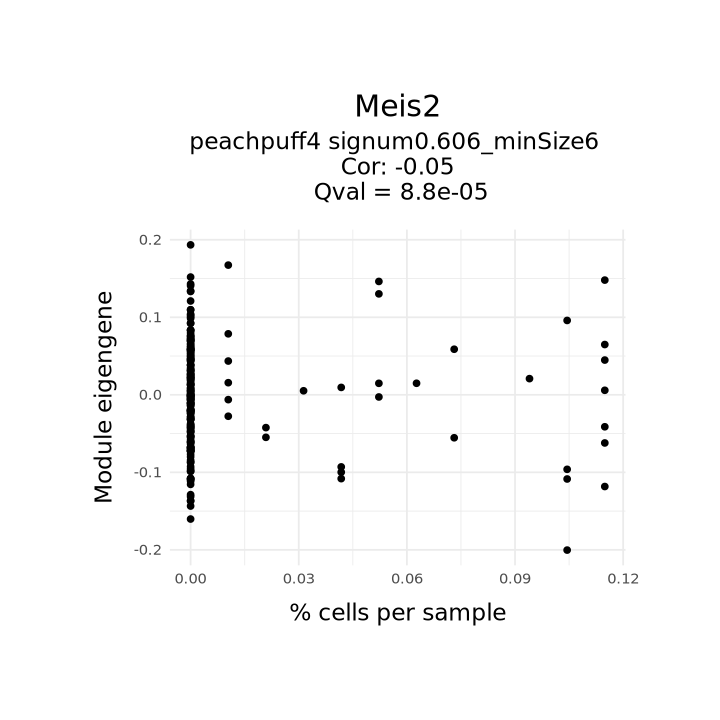

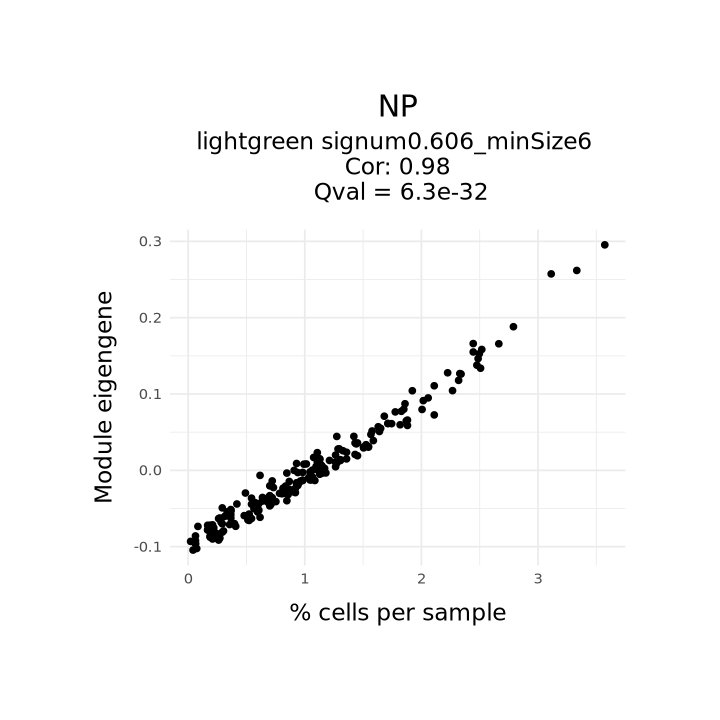

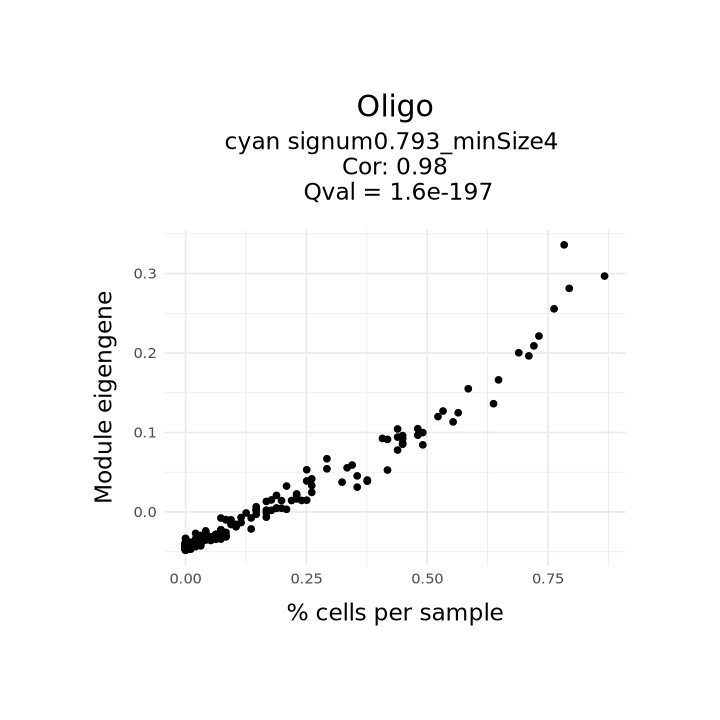

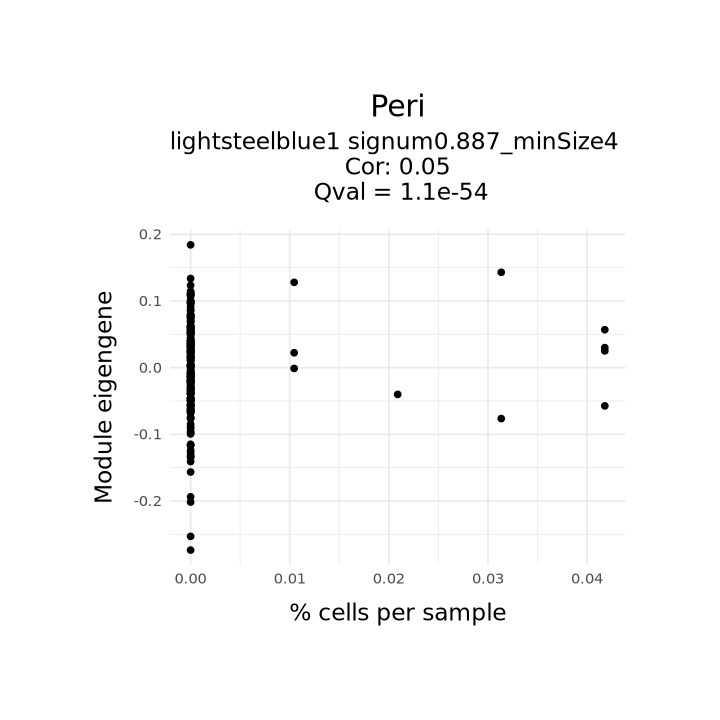

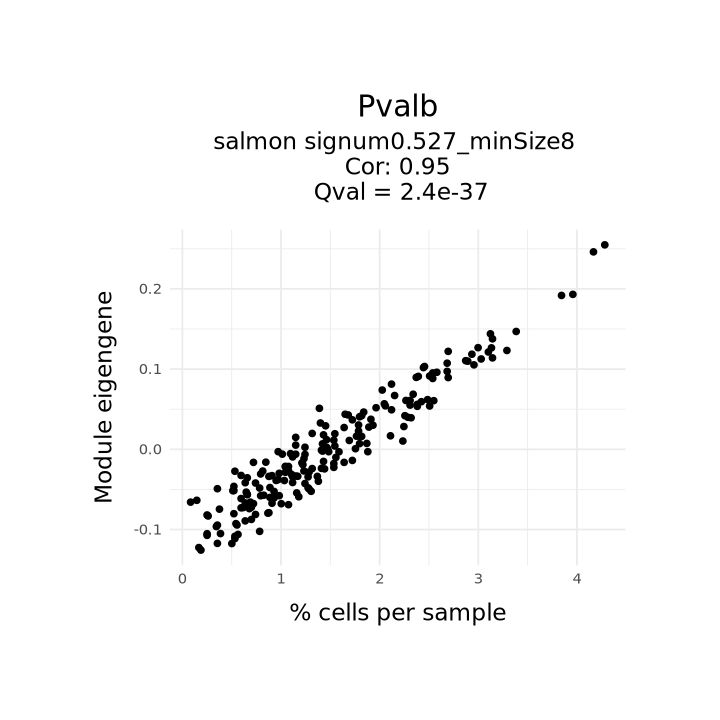

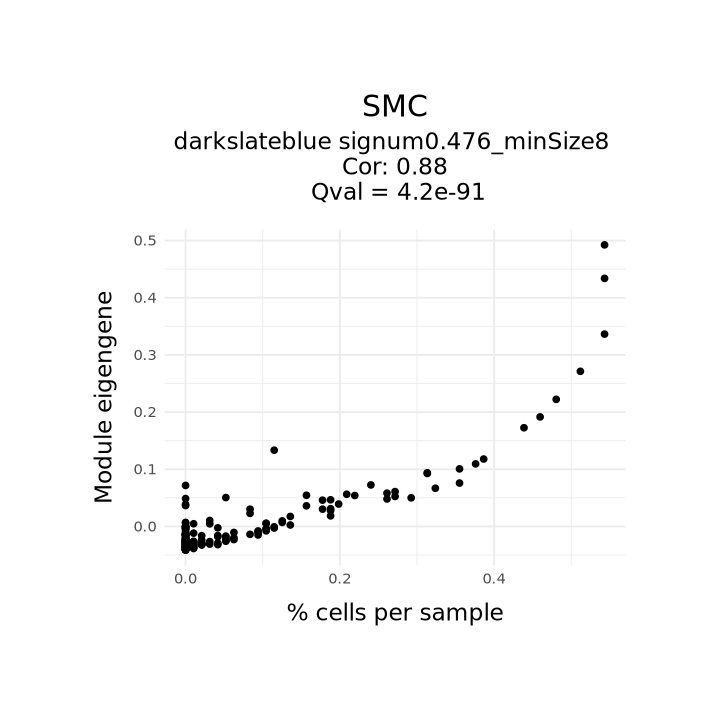

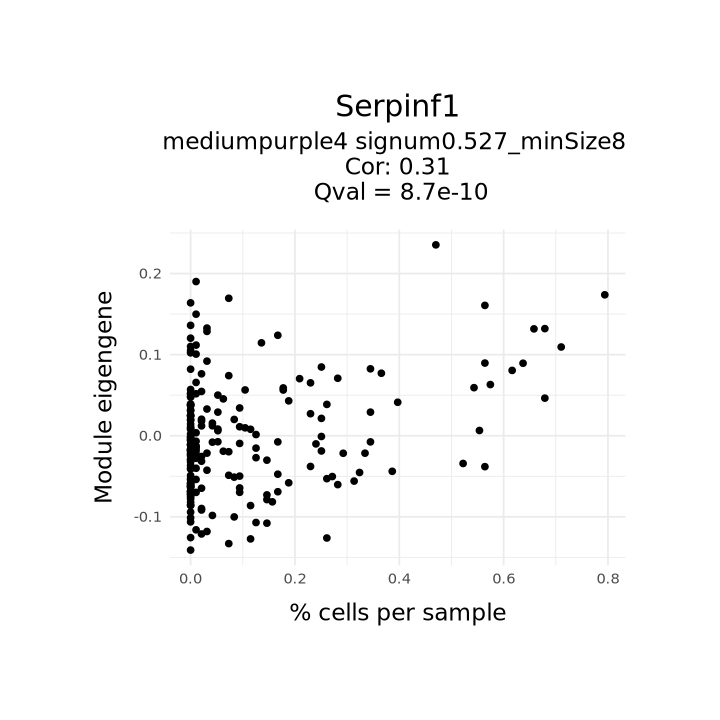

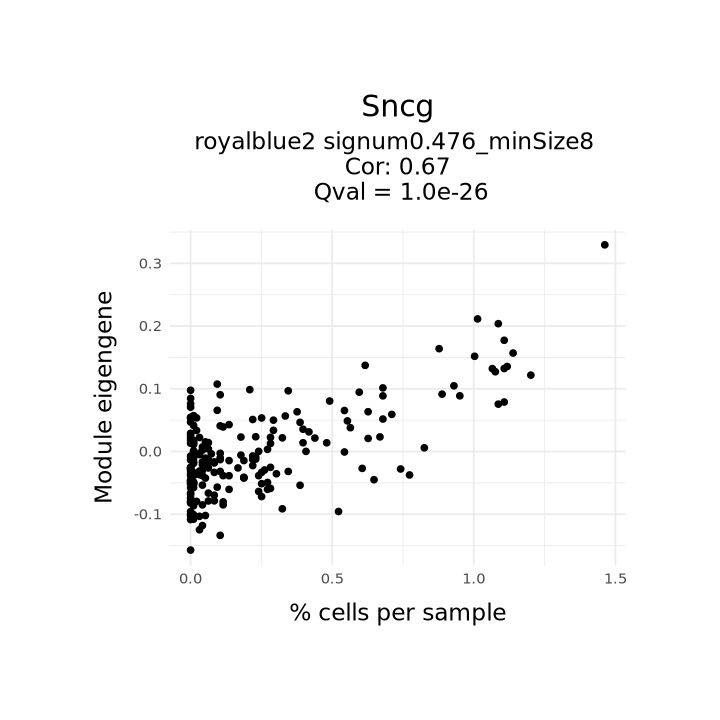

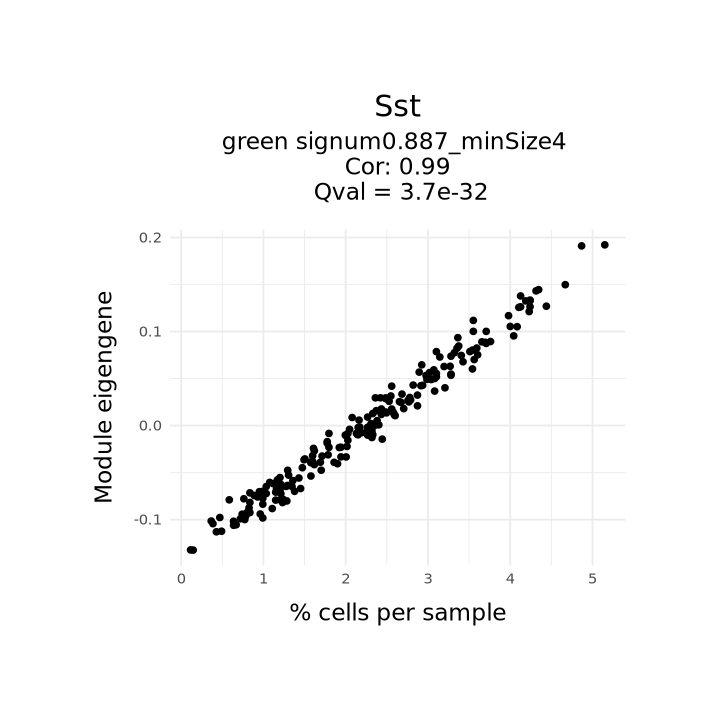

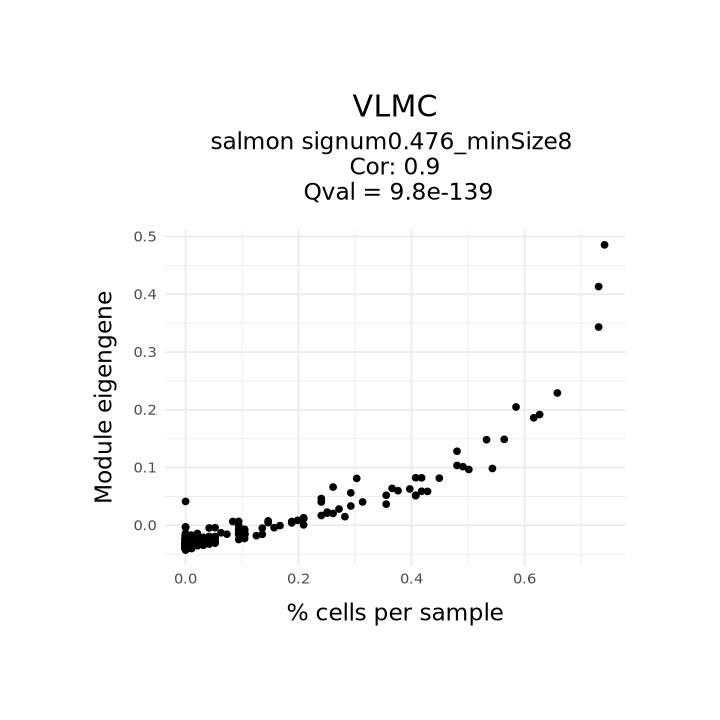

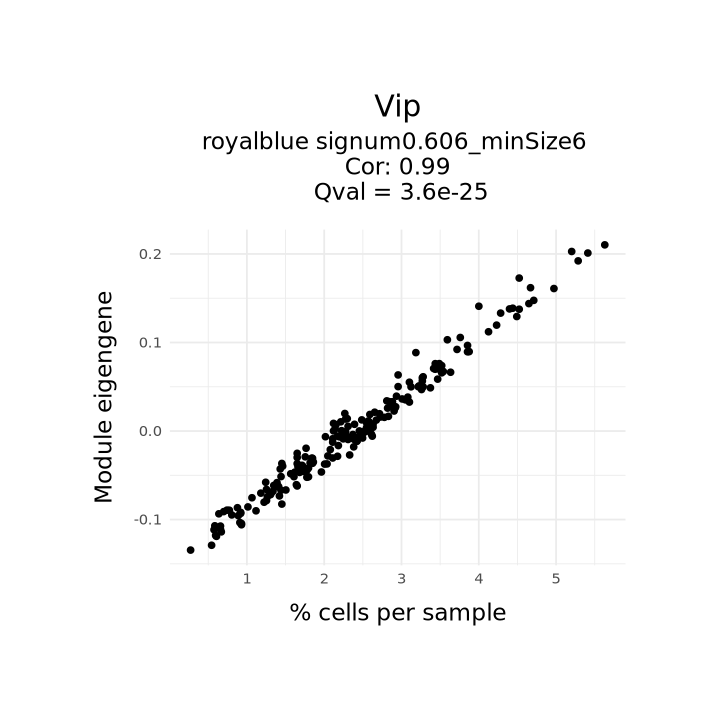

In [270]:
plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

# Round 10 (40% var network w/ bug fixed, PosBC module definition)

In [271]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_40pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_40pcntVar_200samples_legend_11-31-54.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_40pcntVar_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

In [272]:
top_corr_mods_40pcnt_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_40pcnt_PosBC_df

,Cell_type,Cor,Old_cor,Module,Old_module,Network,Old_network,Pseudobulk_SD,New_ME_path
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
sienna,Meis2,0.1838519,-0.02886646,sienna,darkorange2,Bicor-None_signum0.317_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.466_minSize10_merge_ME_0.9_20151,0.77,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_40pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.317_minSize5_merge_ME_0.9_20151/Module_eigengenes_10-40-52.csv
hotpink,L4,0.1876338,-0.02812019,hotpink,dodgerblue4,Bicor-None_signum0.466_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.466_minSize4_merge_ME_0.9_20151,0.73,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_40pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.466_minSize4_merge_ME_0.9_20151/Module_eigengenes_09-00-58.csv
deepskyblue2,CR,0.1965684,0.02735208,deepskyblue2,lightskyblue,Bicor-None_signum0.317_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.466_minSize4_merge_ME_0.9_20151,0.79,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_40pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.317_minSize5_merge_ME_0.9_20151/Module_eigengenes_10-40-52.csv
sienna1,Sncg,0.2721528,0.21875336,sienna,darkred,Bicor-None_signum0.466_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.864_minSize3_merge_ME_0.9_20151,5.96,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_40pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.466_minSize4_merge_ME_0.9_20151/Module_eigengenes_09-00-58.csv
lightyellow1,Serpinf1,0.4588215,0.43717272,lightyellow1,azure2,Bicor-None_signum0.466_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.317_minSize5_merge_ME_0.9_20151,3.51,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_40pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.466_minSize4_merge_ME_0.9_20151/Module_eigengenes_09-00-58.csv
mediumorchid1,Peri,0.6550119,-0.03376494,mediumorchid1,skyblue,Bicor-None_signum0.37_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.723_minSize6_merge_ME_0.9_20151,0.81,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_40pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.37_minSize5_merge_ME_0.9_20151/Module_eigengenes_09-51-23.csv
royalblue,VLMC,0.7861000,0.73898622,royalblue,saddlebrown,Bicor-None_signum0.317_minSize10_merge_ME_0.9_20151,Bicor-None_signum0.723_minSize4_merge_ME_0.9_20151,3.28,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_40pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.317_minSize10_merge_ME_0.9_20151/Module_eigengenes_11-43-37.csv
dodgerblue4,Oligo,0.7864503,0.74685916,dodgerblue4,lightcyan,Bicor-None_signum0.37_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.723_minSize6_merge_ME_0.9_20151,4.24,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_40pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.37_minSize5_merge_ME_0.9_20151/Module_eigengenes_09-51-23.csv
lemonchiffon4,L6_IT,0.7953391,0.65099202,lemonchiffon4,mediumpurple4,Bicor-None_signum0.317_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.466_minSize6_merge_ME_0.9_20151,16.26,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_40pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.317_minSize5_merge_ME_0.9_20151/Module_eigengenes_10-40-52.csv


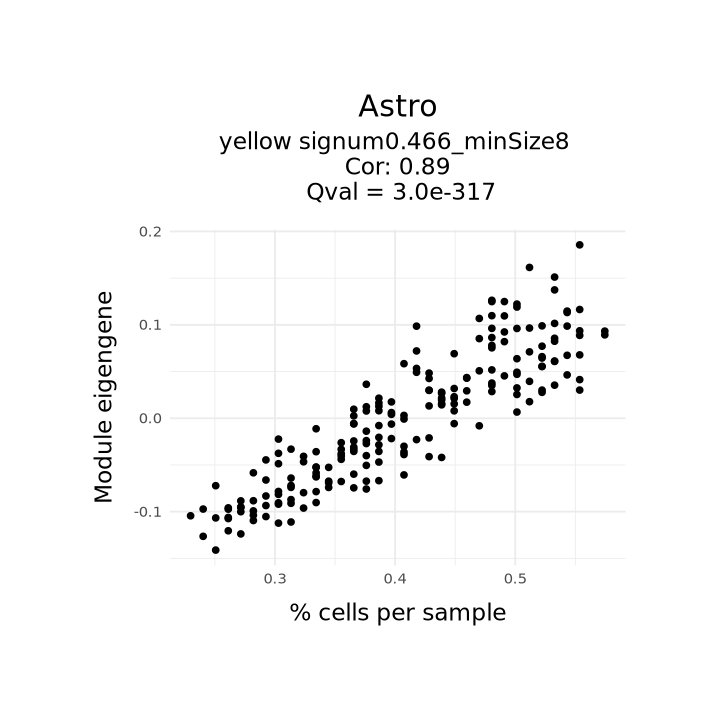

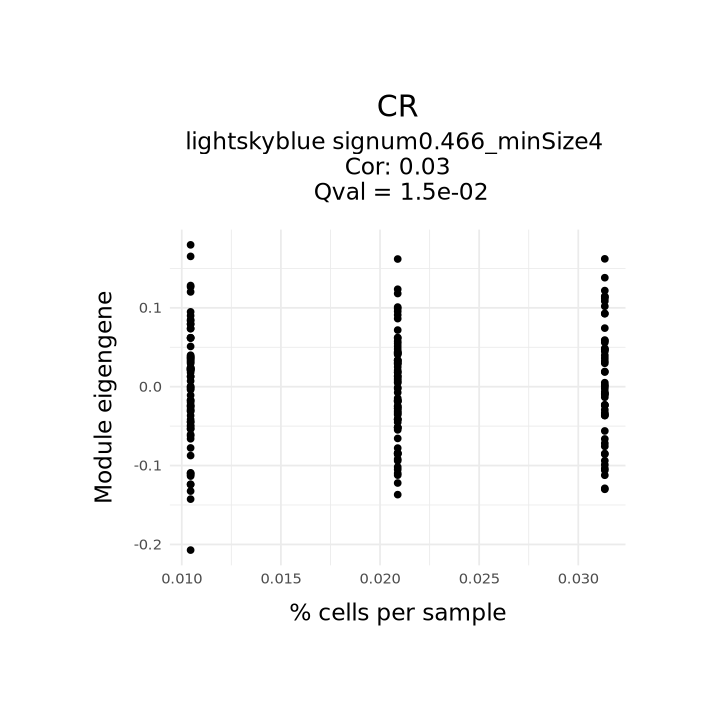

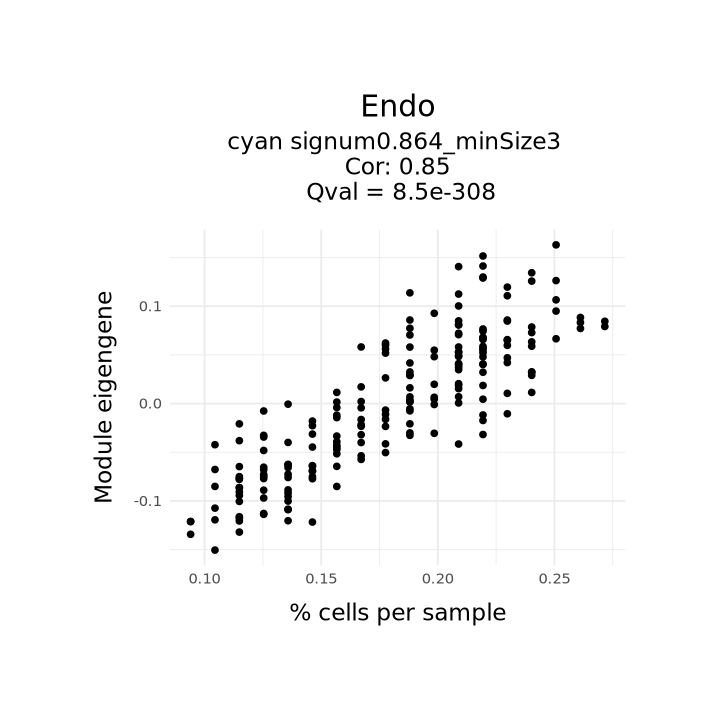

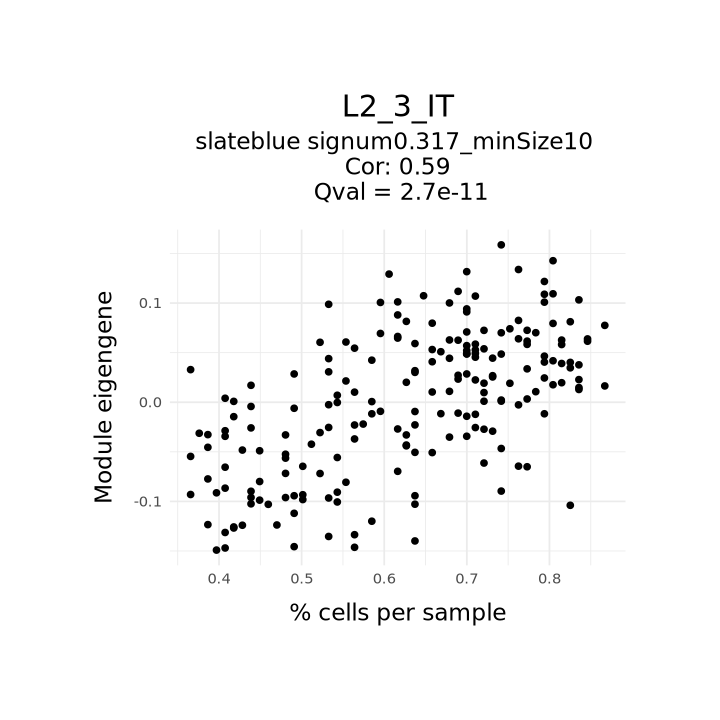

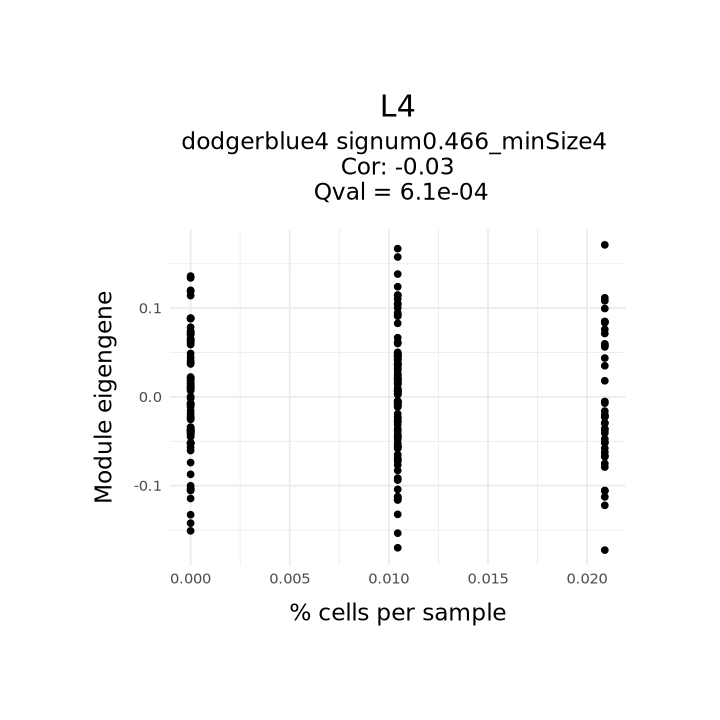

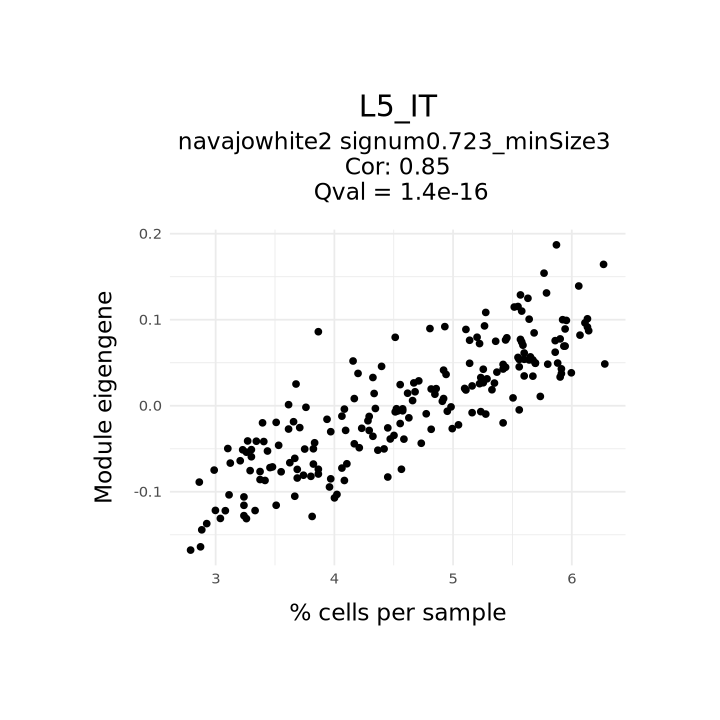

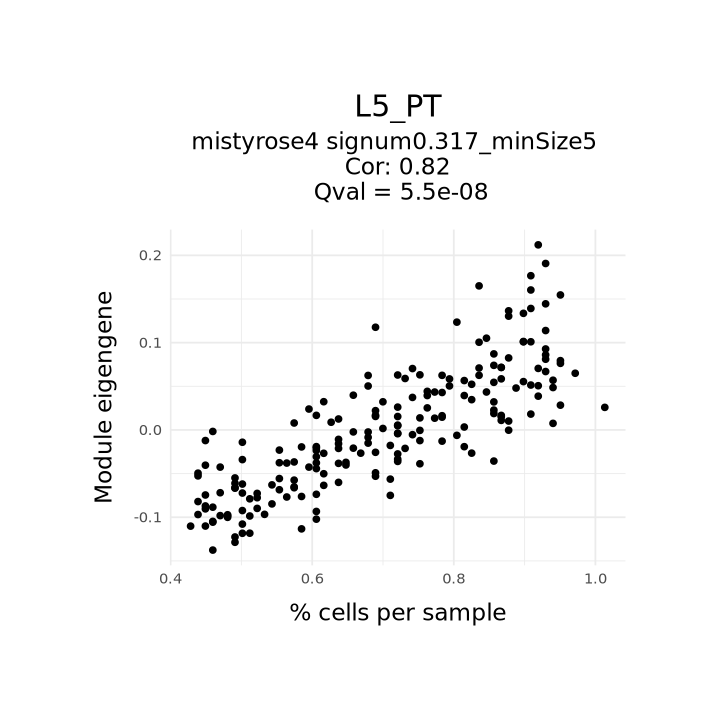

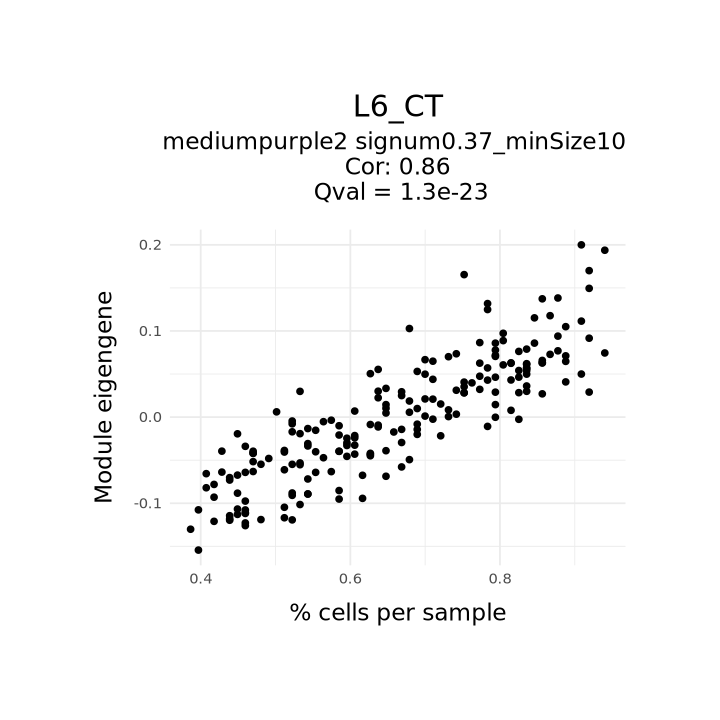

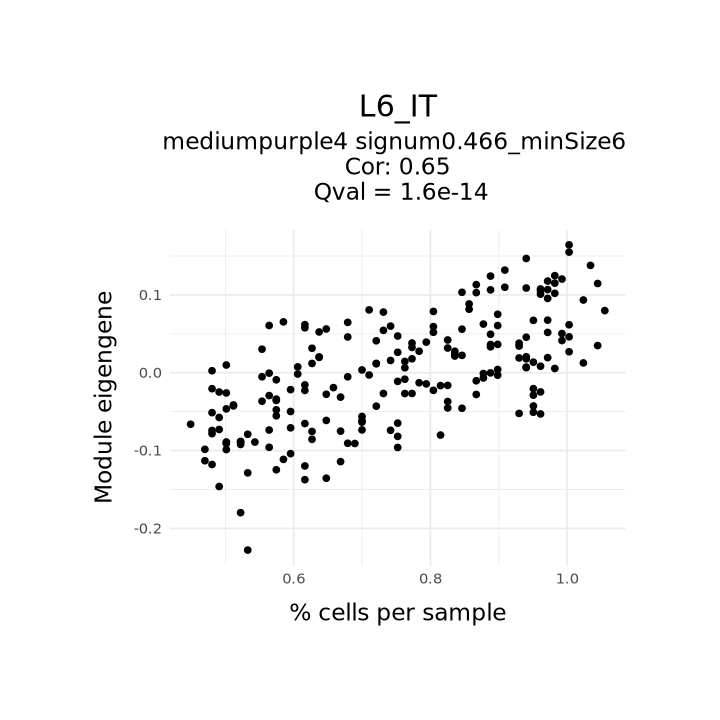

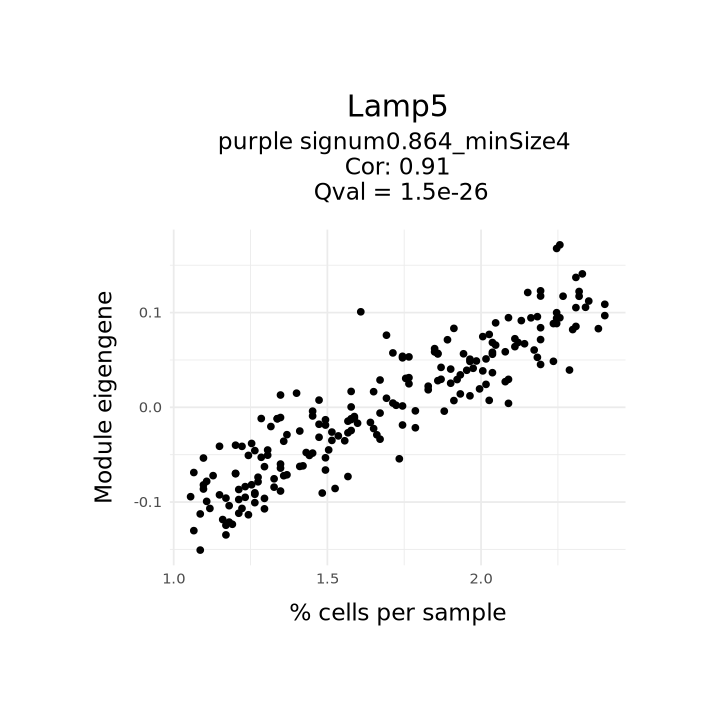

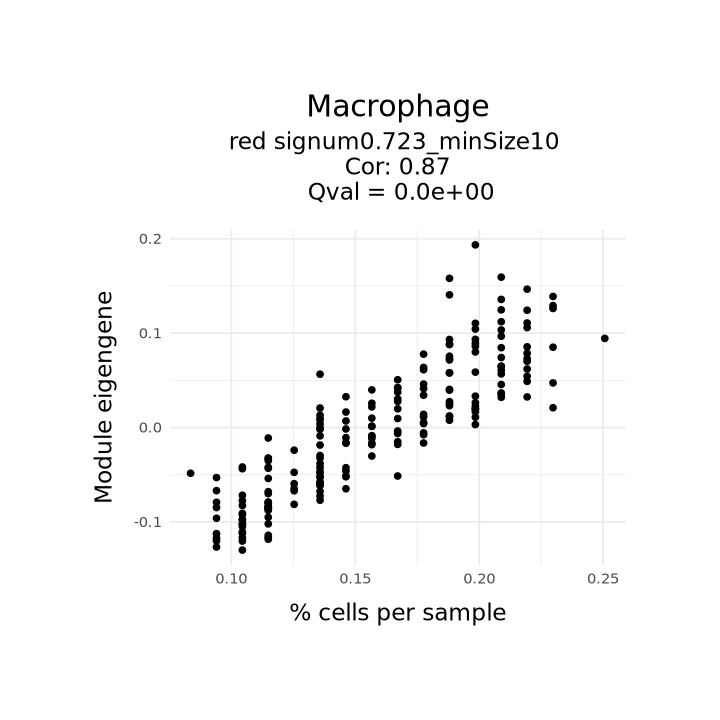

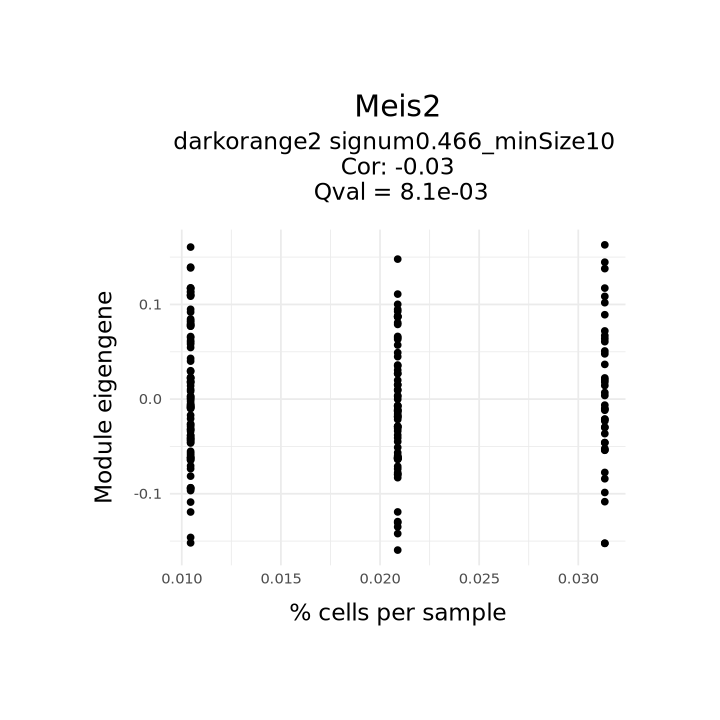

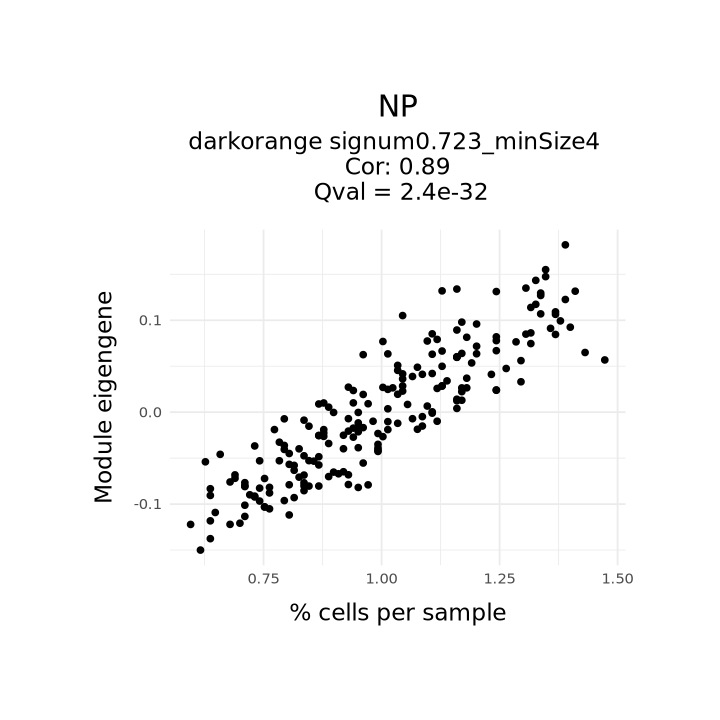

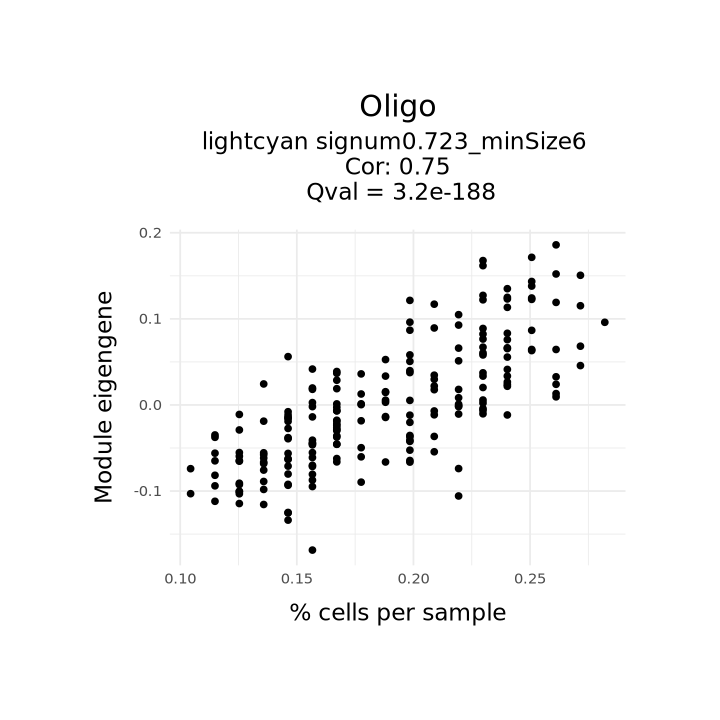

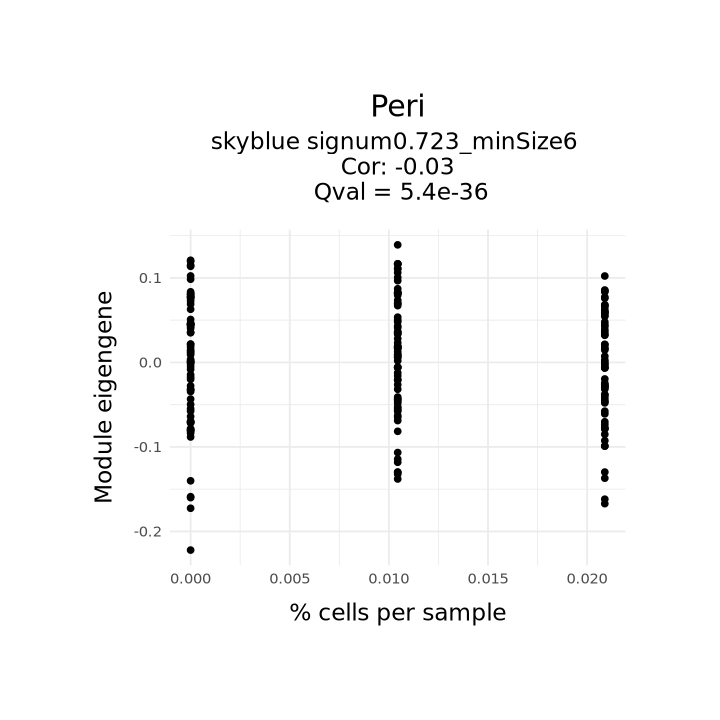

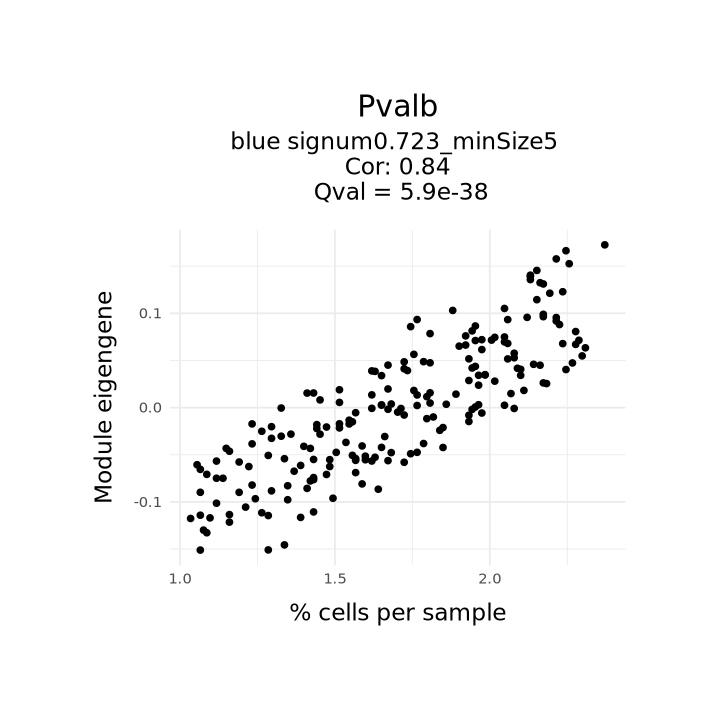

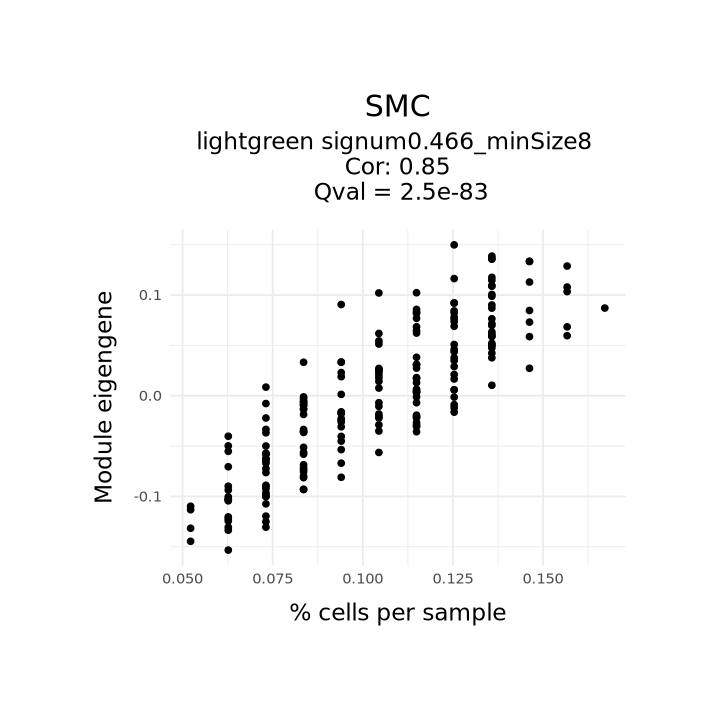

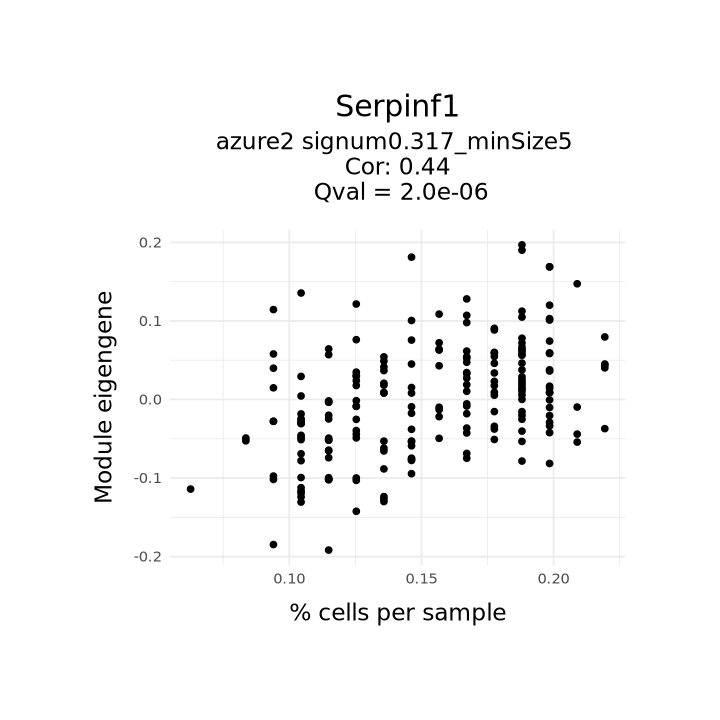

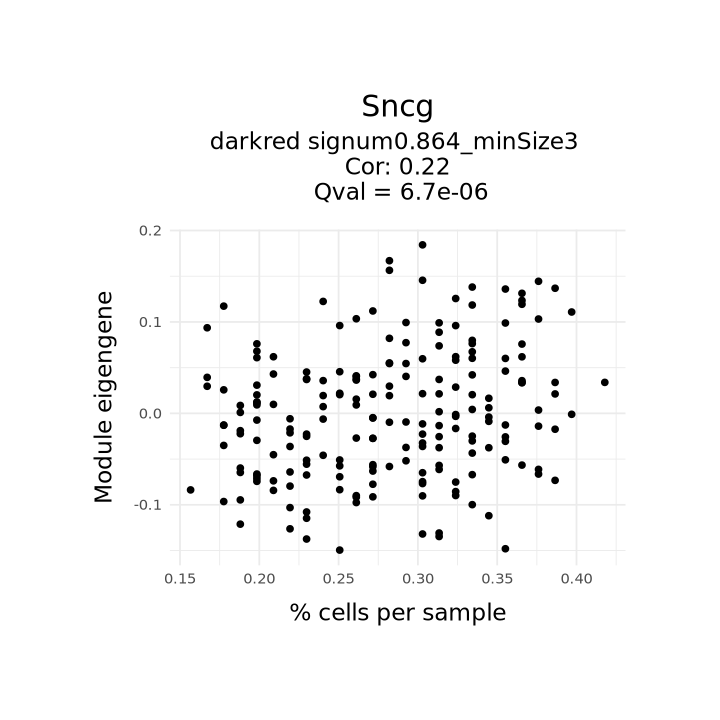

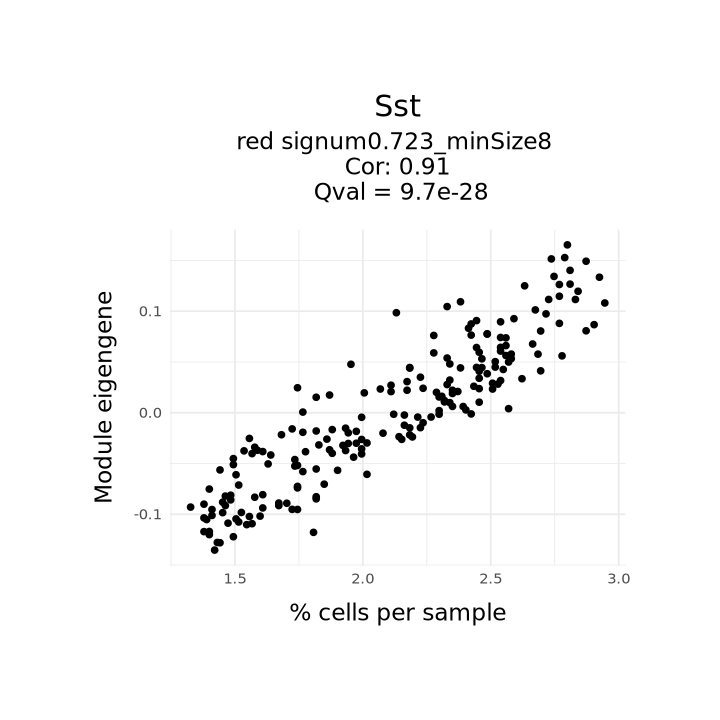

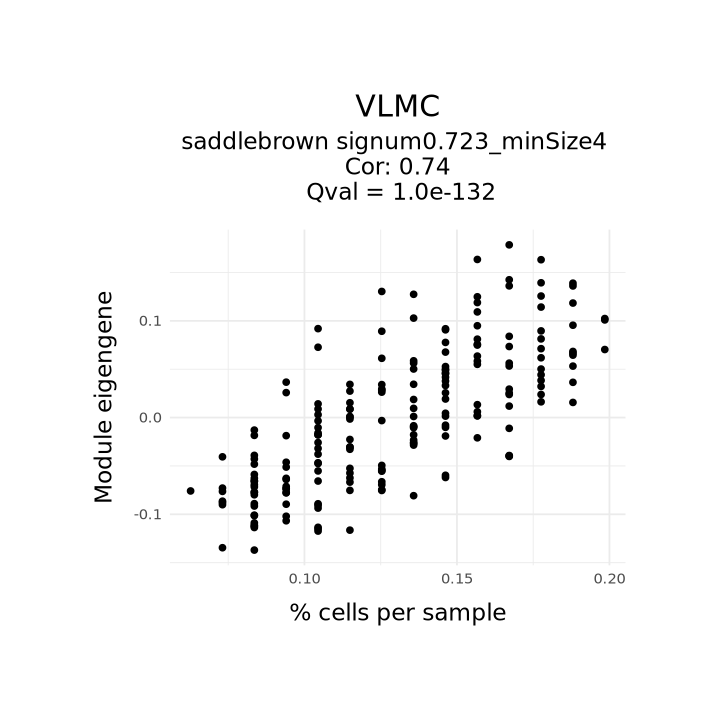

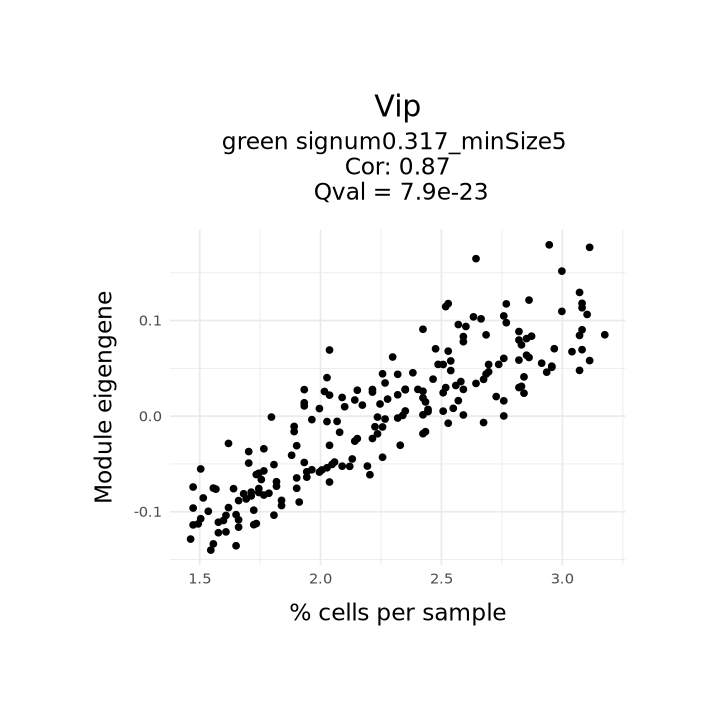

In [273]:
plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

# Concatonate results

In [275]:
top_corr_mods_0.4pcnt_PosBC_df$Data <- "0.4pcnt_PosBC"
top_corr_mods_25kappa_PosBC_df$Data <- "25kappa_PosBC"
top_corr_mods_40pcnt_PosBC_df$Data <- "40pcnt_PosBC_fix"
top_corr_mods_50pcnt_PosBC_df$Data <- "50pcnt_PosBC"

In [278]:
top_corr_mods_0.4pcnt_PosBC_df <- get_top_corr_mod_stats(top_corr_mods_0.4pcnt_PosBC_df)
top_corr_mods_25kappa_PosBC_df <- get_top_corr_mod_stats(top_corr_mods_25kappa_PosBC_df)
top_corr_mods_40pcnt_PosBC_df <- get_top_corr_mod_stats(top_corr_mods_40pcnt_PosBC_df)
top_corr_mods_50pcnt_PosBC_df <- get_top_corr_mod_stats(top_corr_mods_50pcnt_PosBC_df)

In [279]:
cols_idx <- which(colnames(top_corr_mods_0.4pcnt_PosBC_df) %in% c("Cell_type", "Cor", "Old_cor", "Pseudobulk_SD", "PC1V1", "MeanExpr", "Unique_members", "Specificity", "Homogeneity"))

In [282]:
colnames(top_corr_mods_0.4pcnt_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_0.4pcnt_PosBC_df)[-1], "_", top_corr_mods_0.4pcnt_PosBC_df$Data[1]
)

colnames(top_corr_mods_25kappa_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_25kappa_PosBC_df)[-1], "_", top_corr_mods_25kappa_PosBC_df$Data[1]
)

colnames(top_corr_mods_40pcnt_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_40pcnt_PosBC_df)[-1], "_", top_corr_mods_40pcnt_PosBC_df$Data[1]
)

colnames(top_corr_mods_50pcnt_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_50pcnt_PosBC_df)[-1], "_", top_corr_mods_50pcnt_PosBC_df$Data[1]
)

### Compare PosBC results

In [284]:
top_corr_mods_BC_df <- merge(
    top_corr_mods_0.4pcnt_PosBC_df[,cols_idx],
    top_corr_mods_25kappa_PosBC_df[,cols_idx],
    by="Cell_type", all=TRUE, sort=FALSE
)

top_corr_mods_BC_df <- merge(
    top_corr_mods_BC_df,
    top_corr_mods_40pcnt_PosBC_df[,cols_idx],
    by="Cell_type", all=TRUE, sort=FALSE
)

top_corr_mods_BC_df <- merge(
    top_corr_mods_BC_df,
    top_corr_mods_50pcnt_PosBC_df[,cols_idx],
    by="Cell_type", all=TRUE, sort=FALSE
)

top_corr_mods_BC_df <- top_corr_mods_BC_df[,order(colnames(top_corr_mods_BC_df))]

top_corr_mods_BC_df <- merge(
    top_corr_mods_BC_df,
    data.frame(sort(table(cell_meta$cell_subclass))), 
    by.x="Cell_type", by.y="Var1", all=TRUE
)


In [287]:
top_corr_mods_0.4pcnt_PosBC_df[top_corr_mods_0.4pcnt_PosBC_df$Cell_type == "Sncg",]

,Cell_type,Cor_0.4pcnt_PosBC,Old_cor_0.4pcnt_PosBC,Module_0.4pcnt_PosBC,Old_module_0.4pcnt_PosBC,Network_0.4pcnt_PosBC,Old_network_0.4pcnt_PosBC,Pseudobulk_SD_0.4pcnt_PosBC,New_ME_path_0.4pcnt_PosBC,Data_0.4pcnt_PosBC,Mod_stats_path_0.4pcnt_PosBC,Unique_members_0.4pcnt_PosBC,Specificity_0.4pcnt_PosBC,Homogeneity_0.4pcnt_PosBC,PC1VE_0.4pcnt_PosBC,MeanExpr_0.4pcnt_PosBC
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
darkorchid2,Sncg,0.8643323,0.598679,darkorchid2,brown2,Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.255_minSize10_merge_ME_0.9_20151,8.13,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151/Module_eigengenes_06-18-43.csv,0.4pcnt_PosBC,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151/Module_statistics_06-18-43.csv,10,15.87302,0.9213077,0.848987,0.3384607


In [289]:
kME_df <- fread("/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151/kME_table_06-18-43.csv")

In [297]:
top_genes <- kME_df[kME_df$`TopModPosBC_8.11e-09` == "darkorchid2", c("Gene", "kMEdarkorchid2")] %>% arrange(-kMEdarkorchid2)
top_genes

Gene,kMEdarkorchid2
<chr>,<dbl>
Yjefn3,0.9316706
Krt73,0.9298468
Kctd12,0.9024056
Frem1,0.6609797
Eps8,0.6255660
Necab2,0.5850339
Nr1h4,0.4972390
Smim30,0.4237235
Ell2,0.4021426


In [298]:
write.csv(top_genes, file="top_genes.csv", row.names=FALSE)

In [286]:
top_corr_mods_BC_df %>%
  relocate(Freq, .after=Cell_type) %>%
  arrange(Freq)

Cell_type,Freq,Cor_0.4pcnt_PosBC,Cor_25kappa_PosBC,Cor_40pcnt_PosBC_fix,Cor_50pcnt_PosBC,Homogeneity_0.4pcnt_PosBC,Homogeneity_25kappa_PosBC,Homogeneity_40pcnt_PosBC_fix,Homogeneity_50pcnt_PosBC,MeanExpr_0.4pcnt_PosBC,MeanExpr_25kappa_PosBC,MeanExpr_40pcnt_PosBC_fix,MeanExpr_50pcnt_PosBC,Old_cor_0.4pcnt_PosBC,Old_cor_25kappa_PosBC,Old_cor_40pcnt_PosBC_fix,Old_cor_50pcnt_PosBC,Pseudobulk_SD_0.4pcnt_PosBC,Pseudobulk_SD_25kappa_PosBC,Pseudobulk_SD_40pcnt_PosBC_fix,Pseudobulk_SD_50pcnt_PosBC,Specificity_0.4pcnt_PosBC,Specificity_25kappa_PosBC,Specificity_40pcnt_PosBC_fix,Specificity_50pcnt_PosBC,Unique_members_0.4pcnt_PosBC,Unique_members_25kappa_PosBC,Unique_members_40pcnt_PosBC_fix,Unique_members_50pcnt_PosBC
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
L4,3,NA,NA,0.1876338,0.2015220,NA,NA,0.8080781,0.8518490,NA,NA,0.343608280,0.01048402,NA,NA,-0.02812019,0.07698462,NA,NA,0.73,0.70,NA,NA,2.170767,15.384615,NA,NA,15,16
Peri,4,NA,0.1932410,0.6550119,0.1873673,NA,0.9496533,0.8057173,0.8790533,NA,0.44847966,0.015986219,0.18663322,NA,0.05267446,-0.03376494,-0.16100388,NA,0.65,0.81,0.73,NA,1.272265,50.000000,8.854167,NA,35,13,17
CR,11,0.2291747,0.2303541,0.1965684,0.1490367,0.8710563,0.9159445,0.8596675,0.8927302,1.64015820,0.57507761,0.009611715,0.24836634,0.129101599,-0.06763805,0.02735208,-0.04376170,0.50,1.96,0.79,0.79,15.2284264,3.276898,66.666667,10.283688,60,60,22,29
Meis2,11,0.2845981,0.3125991,0.1838519,0.1785107,0.7874547,0.8567619,0.7744719,0.8068180,0.01416564,0.35663564,0.163390191,0.96078083,0.149229893,-0.05137787,-0.02886646,-0.08011696,0.50,2.71,0.77,0.74,100.0000000,2.027679,7.471264,1.056710,7,63,13,30
SMC,55,0.9590460,0.8800080,0.8518874,0.8828202,0.9391225,0.9295218,0.8130962,0.9908321,0.28830932,0.12901273,0.345694148,0.78549982,0.958120433,0.88000800,0.84966107,0.87072285,2.93,11.55,2.59,4.11,53.4188034,24.531377,79.113924,72.924188,125,301,125,202
VLMC,72,0.9211118,0.9117353,0.7861000,0.8453615,0.9229145,0.9852843,0.7668220,0.9242816,0.19250877,0.26176473,0.182362009,0.18344373,0.921111791,0.90136592,0.73898622,0.83210083,3.63,16.84,3.28,5.17,79.2114695,26.007523,38.783270,70.877193,221,484,102,202
Serpinf1,78,0.7316211,0.4026167,0.4588215,0.1938398,0.6688854,0.9733656,0.8482979,0.8321743,0.49548560,0.29056466,0.433067178,0.93084122,0.276181507,0.30979272,0.43717272,0.07748015,4.20,16.64,3.51,5.23,31.7073171,3.448276,1.511879,0.656304,13,66,14,19
Macrophage,85,0.9739987,0.9965619,0.8802637,0.8790042,0.9833021,0.9982113,0.9720069,0.9938854,0.32976571,0.32746280,0.520008128,0.68189793,0.952347615,0.97445447,0.87331058,0.87358583,4.47,17.12,3.89,5.79,95.4687500,87.630058,76.937618,93.563579,611,1516,407,596
Macrophage,85,0.9739987,0.9965619,0.8802637,0.8790042,0.9833021,0.9982113,0.9720069,0.9938854,0.32976571,0.32746280,0.520008128,0.68189793,0.952347615,0.97445447,0.87331058,0.87409913,4.47,17.12,3.89,5.79,95.4687500,87.630058,76.937618,93.563579,611,1516,407,596


### Some cell types that are not being well identified in **any** dataset:

No modules exist:
- Meis2 (11 cells)
- CR (11 cells)
- Peri (4 cells)
- L4 (3 cells)

Modules exist, but not being identified
- Serpinf1 (78 cells)
- Sncg (148 cells)

Modules exist, "decent" but not great modules being identifeid 
- L2_3_IT (325 cells)

# Misc

In [207]:
plot_cor_vs_stats <- function(cell_meta, top_corr_mods_df) {
    # Get original # cells per cell type
    top_corr_mods_df <- merge(
        top_corr_mods_df,
        data.frame(sort(table(cell_meta$cell_subclass))), 
        by.x="Cell_type", by.y="Var1"
    )
    cor_col <- grep("^Cor", colnames(top_corr_mods_df))
    top_corr_mods_df <- top_corr_mods_df[!is.na(top_corr_mods_df[,cor_col]),] 
    pal <- colorRampPalette(c("navy", "cyan", "yellow", "red"))(200)
    color_vec <- pal[as.numeric(cut(top_corr_mods_df[,cor_col], breaks=200))]
    plot(top_corr_mods_df$Freq, top_corr_mods_df$Pseudobulk_SD, col=color_vec, pch=16)
    plot(top_corr_mods_df$Freq, top_corr_mods_df[,cor_col])
}

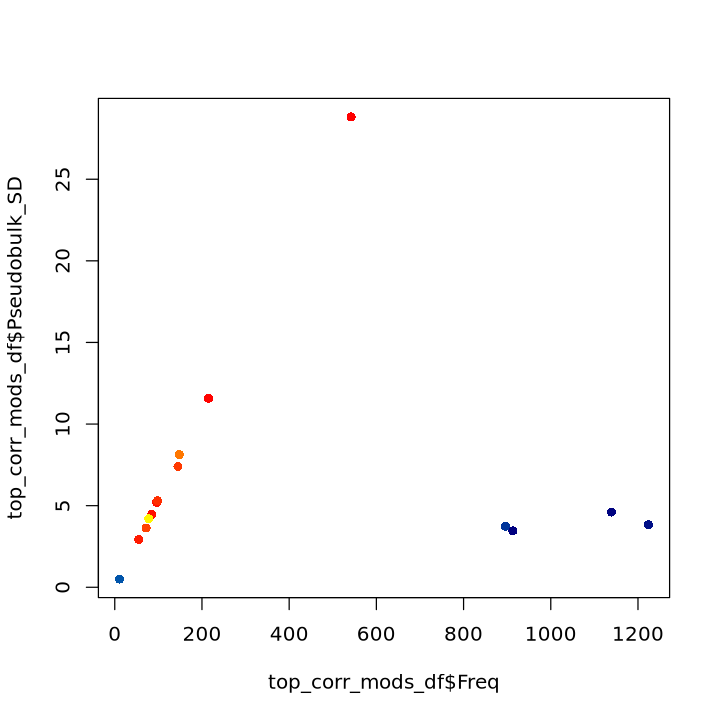

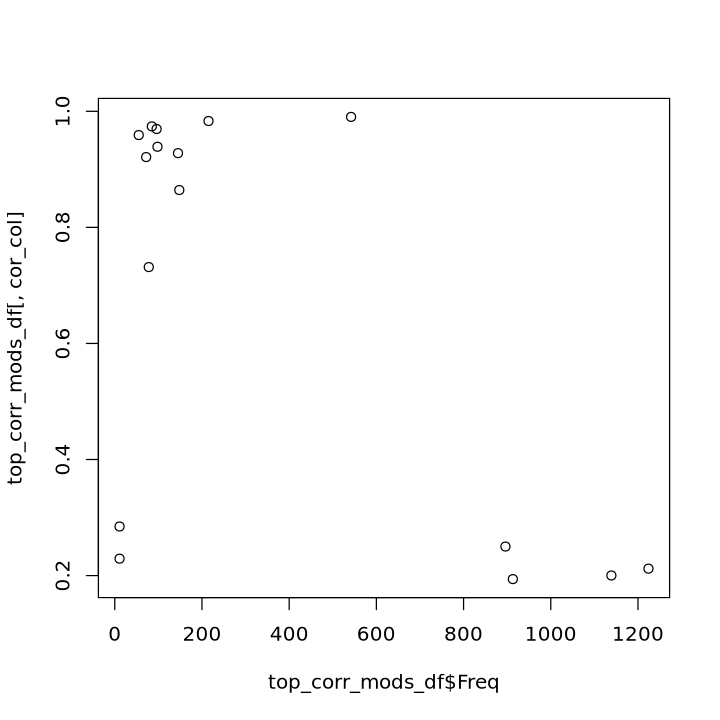

In [208]:
plot_cor_vs_stats(cell_meta, top_corr_mods_0.4pcnt_PosBC_df)

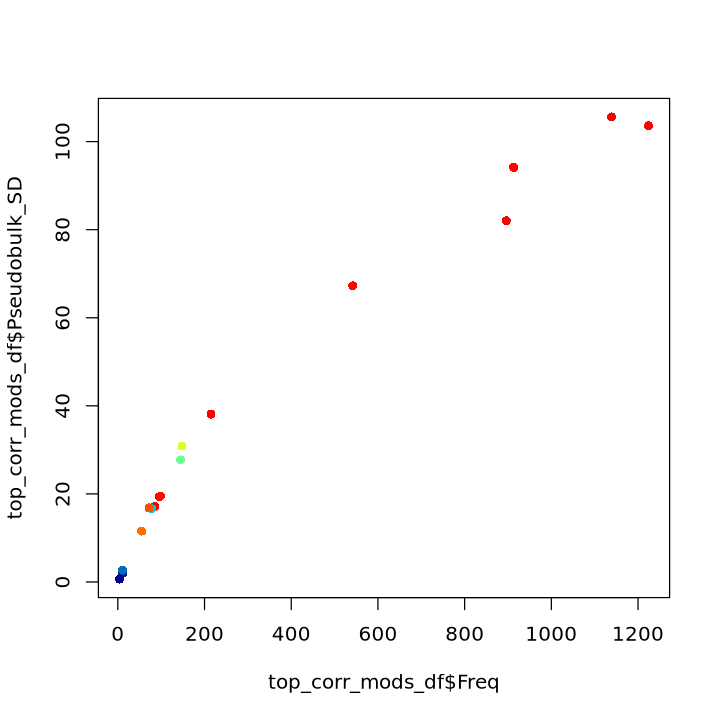

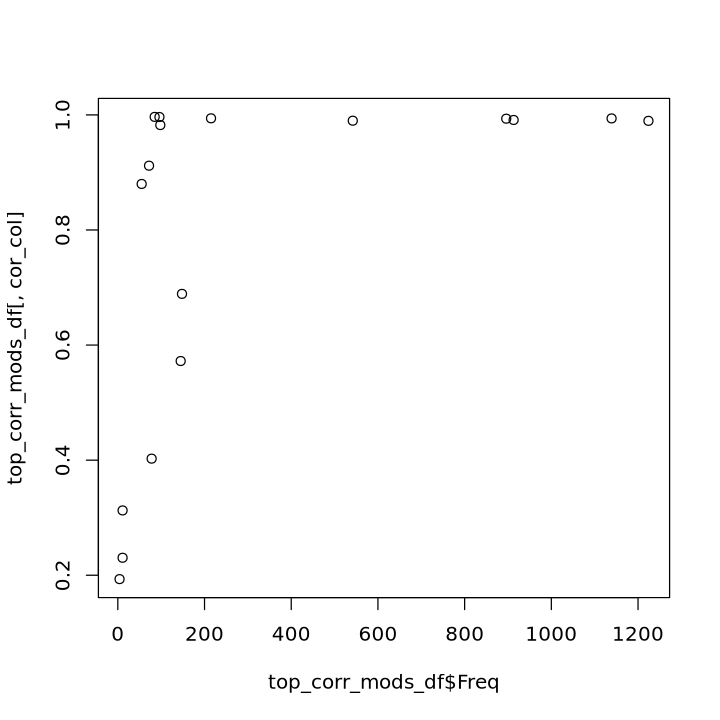

In [209]:
plot_cor_vs_stats(cell_meta, top_corr_mods_25kappa_PosBC_df)

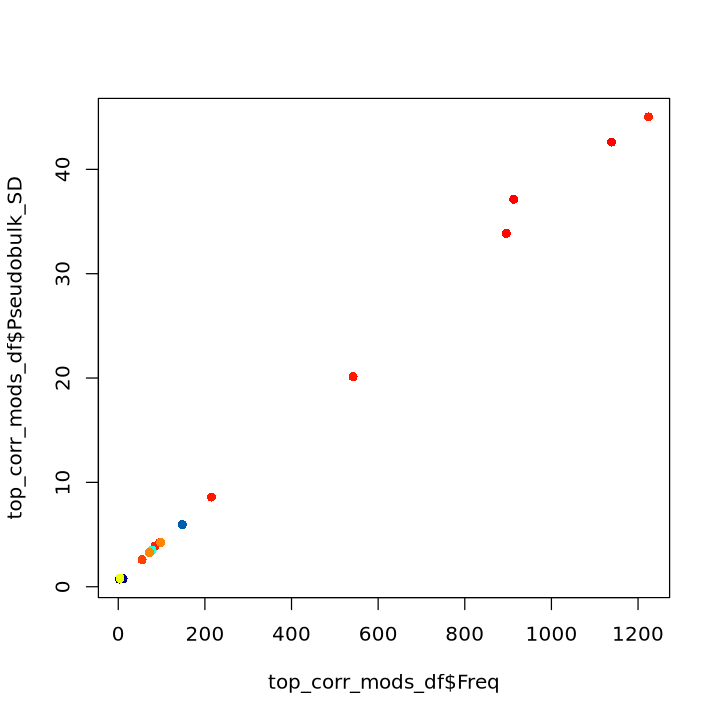

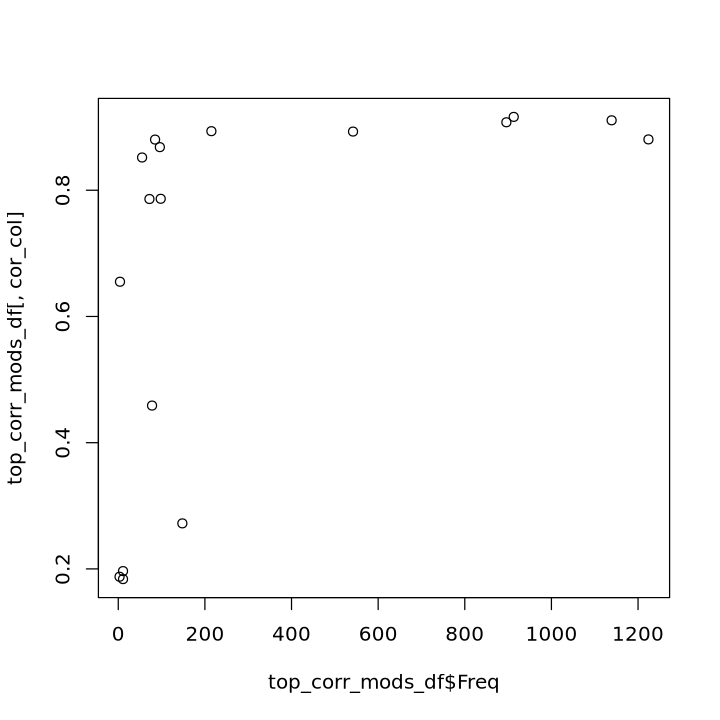

In [210]:
plot_cor_vs_stats(cell_meta, top_corr_mods_40pcnt_PosBC_df)

In [ ]:
# It seems like if variability scales with the raw number of cell types, we can get the modules we need?

# I want uniform sampling around the true fraction of cell types, though, because low correlations for cell types like Serpinf1 seem to be driven by a concentration of lower % cells (closer to the true value)